<a href="https://colab.research.google.com/github/heesukjang/W266_NLP_With_DeepLearning/blob/main/Final_Project/v9_Regression_withBERT_4_5_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Update the version of tensorflow to 2.11.0**

In [3]:
# !pip uninstall tensorflow              # uninstall the current version of tf that Colab automatically installs
# !pip install tensorflow==2.11.0        # install 2.11.0 version, which the model worked at that point with a GPU
# # Next step: go to "Runtime" and "Restart runtime"
# # then confirm if the version is properly updated to 2.11.0 by running the followin print statement - "import tensorflow as tf | print(tf.__version__)"

# Check the version of tensorflow

In [4]:
import tensorflow as tf
print(tf.__version__)

2.11.0


# Install New Libraries

In [5]:
!pip install nltk
!pip install wordcloud
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 28.7 MB/s eta 0:00:00
ERROR: Operation cancelled by user


# **Importing Libraries**

In [6]:
import random

#NLP related libraries
import transformers
print(f'transformers version: {transformers.__version__}')
from transformers import logging as hf_logging
from transformers import BertTokenizer, TFBertModel
hf_logging.set_verbosity_error()
import nltk
from nltk.tokenize import sent_tokenize
import spacy      
from spacy import displacy
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
from sklearn.model_selection import train_test_split
nltk.download('punkt')

# Other required libraries
import os
import pandas as pd
pd.set_option('display.width', 180)    # increase pandas display output in Colab
import numpy as np
import re
import copy
import sys
import datetime
import time
from keras.utils.layer_utils import count_params
import locale
locale.getpreferredencoding = lambda: "UTF-8"
import warnings
warnings.filterwarnings("ignore")

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import load_model

from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: ignored

# **General Functions**

## **Set Config Parameters**

In [ ]:
def set_config_param(seed = 99):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_columns', None)
    
    
set_config_param(20230214)

## **Count Plot**

In [ ]:
# def plot_count(df, labels):
#   sns.set_style('whitegrid')
#   plt.figure(figsize=(18,10))
#   for idx, label in enumerate(labels):
#       plt.subplot(2, 3, idx+1)
#       sns.countplot(x = label, data = df)

## **Adding Feature Columns**

In [ ]:
def add_feature(df):

    # Cleaning up full_text : Removing tabl and carriage return characters
    df['full_text'] = df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

    # Adding word count, sentence count, total score and full text length
    df['word_count'] = df['full_text'].apply(lambda x: len(x.split()))
    df['sentence_count'] = df['full_text'].apply(lambda x: len(sent_tokenize(x)))
    df['total_score'] = df['cohesion'] + df_train['syntax'] + df['vocabulary'] + df['phraseology'] + df['grammar'] + df['conventions']
    df['full_text_len'] = df['full_text'].apply(lambda x: len(x))

    # Adding mean, median score per label and indicator column 
    # whether the label value is below or above mean or median value
    for label in label_cols:
        df[label + '_avg_score'] = np.mean(df[label])
        df[label + '_above_or_below_avg_flag'] = np.where(df[label] > np.mean(df[label]), 1, 0)  
        df[label + '_median_score'] = np.median(df[label])
        df[label + '_above_or_below_median_flag'] = np.where(df[label] > np.median(df[label]), 1, 0)  
        df[label + '_rounded_val'] = np.round(df[label])  
    
    return df

## **Getting Unique Values for Each Label**

In [ ]:
# def get_unique_values_for_labels(df, col_list):
#     print('Unique Values in Each Metric:\n==================================================')
#     for col in col_list:
#         print(f'{col}: {df[col].unique()}')

## **Getting Value Counts for Each Label**

In [ ]:
# def get_value_counts_for_labels(df, col_list):
#     print('Counts for Each Metric:\n==================================================')
#     for col in col_list:
#         print(f"Column: {col}")
#         print(f'{df[col].value_counts().sort_values()}')
#         print("*****")

## **Getting Histogram for a Column**

In [ ]:
# def get_histogram_for_col(df, col_list, col_name):
#     sns.set_style('whitegrid')
#     plt.figure(figsize=(18,10))
#     for idx, label in enumerate(col_list):
#         plt.subplot(2, 3, idx+1)
#         sns.histplot(x=col_name, hue = label, data = df)
#         plt.xlabel('Word Count', fontsize=10)

## **Getting Count Plot for Indicator Columns**

In [ ]:
# def get_count_plot_for_ind_col(df, search_string, col_list):
#     fig, ax = plt.subplots(1, len(col_list), figsize=(50,10))
#     for idx, label in enumerate(col_list):
#         sns.countplot(x = df[label + search_string], ax = ax[idx])
#         ax[idx].set_title(label)

## **Getting Bar Plot for Each Label**

In [ ]:
# def get_barplot_for_each_label(df, col_list, search_string):
#     avg_score_cols = [col + search_string for col in col_list]
#     plt.figure(figsize=(8,5))
#     ax = sns.barplot(x=col_list, y=np.array(df[avg_score_cols].drop_duplicates())[0], palette='rocket')
#     plt.xlabel('Scoring Metric', fontsize=12)
#     if search_string == '_avg_score':
#         plt.ylabel('Average Score', fontsize=12)
#         plt.title('Average Score in Each Metric', fontsize=16)
#     elif search_string == '_median_score':
#         plt.ylabel('Median Score', fontsize=12)
#         plt.title('Median Score in Each Metric', fontsize=16)

## **Label Processing**

In [ ]:
def get_cat_label_cols(col_list):
    return ['cat_' + col for col in col_list]

In [ ]:
def apply_label_map(df, label_map, col_list):
  for col in col_list:
      df[col + '_map'] = df[col].map(label_map)
  return df

In [ ]:
def get_label_values(df, col_list):
    return [np.array(df[col]) for col in col_list]

In [ ]:
def get_label_dict(df, col_list_1, col_list_2):
    return dict(zip(col_list_2, get_label_values(df, col_list_1)))

## **Plot Loss and Accuracy**

In [ ]:
# def plot_loss_accuracy(history, col_list):
#     fig, ax = plt.subplots(2, 6, figsize=(16, 6), sharex='col', sharey='row')
#     fig.tight_layout(pad=5.0)
#     for idx, col in enumerate(col_list):

#         ax[0, idx].plot(history[col + '_loss'], lw=2, color='darkgoldenrod')
#         ax[0, idx].plot(history['val_' + col + '_loss'], lw=2, color='indianred')
#         #ax[0, idx].legend(loc='center left')
#         ax[0, idx].legend(['Train', 'Validation'], fontsize=5)
#         ax[0, idx].set_xlabel('Epochs', size=10)
#         ax[0, idx].set_title('Loss: ' + col)

#         ax[1, idx].plot(history[col + '_accuracy'], lw=2, color='darkgoldenrod')
#         ax[1, idx].plot(history['val_' + col + '_accuracy'], lw=2, color='indianred')
#         #ax[0, idx].legend(loc='center left')
#         ax[1, idx].legend(['Train', 'Validation'], fontsize=5)
#         ax[1, idx].set_xlabel('Epochs', size=10)
#         ax[1, idx].set_title('Accuracy: ' + col)

##**[MCRMSE (Mean Column-wise Root Mean Squared Error)](https://www.kaggle.com/competitions/feedback-prize-english-language-learning/overview/evaluation)**<br>
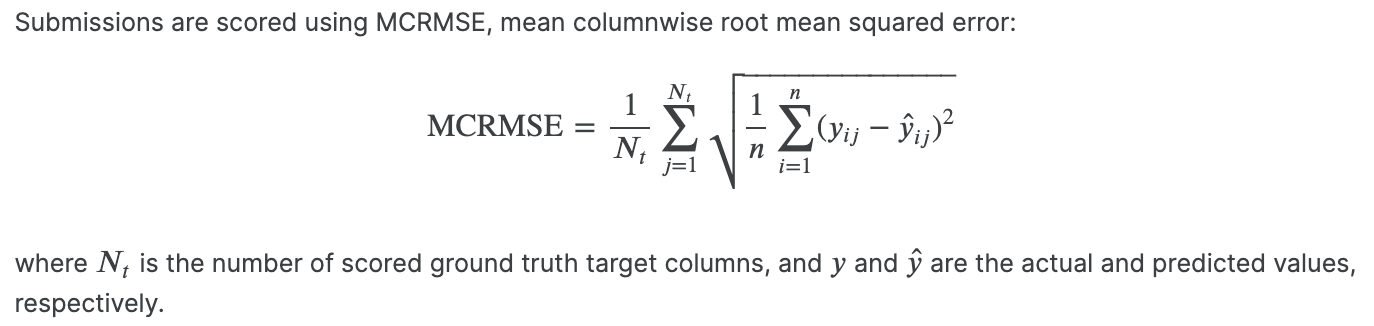

In [ ]:
# !pip install tensorflow-addons
# import tensorflow_addons as tfa
# y_true = np.array([1, 4, 3], dtype=np.float32)
# y_pred = np.array([2, 4, 4], dtype=np.float32)
# metric = tfa.metrics.r_square.RSquare()
# metric.update_state(y_true, y_pred)
# result = metric.result()
# result.numpy()

In [ ]:
def MCRMSE(y_true, y_pred):
  colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
  return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# https://medium.com/ilb-labs-publications/fine-tuning-bert-for-a-regression-task-is-a-description-enough-to-predict-a-propertys-list-price-cf97cd7cb98a
def mae_mdae(y_true, y_pred):  
  mae = mean_absolute_error(y_true, y_pred)
  mdae = median_absolute_error(y_true, y_pred)
  return mae, mdae

In [ ]:
# def r_squared(y_true, y_pred):
#   # r_squared = r2_score(y_true, y_pred)
#   total_error = tf.reduce_sum(tf.square(tf.sub(y, tf.reduce_mean(y))))
#   unexplained_error = tf.reduce_sum(tf.square(tf.sub(y, prediction)))
#   r_squared = tf.sub(1, tf.div(unexplained_error, total_error))
#   return r_squared  

# # regression_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
# #                         loss=MCRMSE,
# #                         metrics=MCRMSE) 

# **Load Input Files**

In [ ]:
train_path = '/content/gdrive/MyDrive/Kaggle/train.csv'
test_path = '/content/gdrive/MyDrive/Kaggle/test.csv'

input_train_df = pd.read_csv(train_path)
input_test_df = pd.read_csv(test_path)

# input_train_df = pd.read_csv('train.csv')
# input_test_df = pd.read_csv('test.csv')

float_labels, int_map_labels = np.arange(1, 5.5, 0.5), np.arange(9)
label_map = dict(zip(float_labels, int_map_labels))

float_scaled_labels, int_scaled_labels = np.arange(1, 6, 1), np.arange(6)
label_scaled_map = dict(zip(float_scaled_labels, int_scaled_labels))

orig_train_df = copy.deepcopy(input_train_df)
orig_train_df.head()

"Map" columns are basically scaled columns of the original metric values. There are total 9 levels in map columns. Original mretric columns range from 1 to 5. Through map columns, they range from 0 to 8.

"Scaled" columns map numbers .5, 1.5, 2.5, 3.5 and 4.5 to nearset integers. Thus it will have range from 1 to 5.

In [ ]:
label_map

In [ ]:
label_scaled_map

# **Split Data** into **3 Dataframes**
- df_train
- df_val
- df_test

Original test data is very limited, there are only 3 records and it does not have labels to test. So we decided to repurpose the given train data to split into train, test and validation sets.

In [ ]:
shuffle = np.random.permutation(np.arange(orig_train_df.shape[0]))
orig_train_df = orig_train_df.iloc[shuffle]
split=(0.8,0.1,0.1)
splits = np.multiply(len(orig_train_df), split).astype(int)
df_train, df_val, df_test = np.split(orig_train_df, [splits[0], splits[0] + splits[1]])
df_train.head()

In [ ]:
label_cols = df_train.columns[2:]
print(label_cols)
label_rounded_cols = [col + '_rounded_val' for col in label_cols]
label_map_cols = [col + '_map' for col in label_cols]
cat_label_cols = get_cat_label_cols(label_cols)

df_train = apply_label_map(df_train, label_map, label_cols)
df_test = apply_label_map(df_test, label_map, label_cols)
df_val = apply_label_map(df_val, label_map, label_cols)

In [ ]:
label_cols, label_rounded_cols, label_map_cols, cat_label_cols

# **Addiung Other Feature Columns**

In [ ]:
df_train = add_feature(df_train)
df_test = add_feature(df_test)
df_val = add_feature(df_val)

# **EDA**

In [ ]:
df_train.head()

In [ ]:
for col in label_cols:
    print(df_train[col + '_rounded_val'].unique())

In [ ]:
df_train.iloc[0]

In [ ]:
df_test.head()

In [ ]:
df_val.head()

In [ ]:
df_train.shape, df_test.shape, df_val.shape

In [ ]:
df_train.describe()

In [ ]:
# df_train.columns

## **Unique Values for Each Label**

In [ ]:
# get_unique_values_for_labels(df_train, label_cols)

## **Unique Values for Each Rounded Label**

In [ ]:
# get_unique_values_for_labels(df_train, label_rounded_cols)

## **Value Counts for Each Label**

In [ ]:
# get_value_counts_for_labels(df_train, label_cols)

In [ ]:
# plot_count(df_train, label_cols)

## **Value Counts for Each Rounded Label**

In [ ]:
# get_value_counts_for_labels(df_train, label_rounded_cols)

In [ ]:
# plot_count(df_train, label_rounded_cols)

## **Full Text Length Stats**

In [ ]:
# df_train.full_text.str.len().describe()

## **Word Count Stats**

In [ ]:
# df_train.word_count.describe()

## **Sentence Count Stats**

In [ ]:
# df_train.sentence_count.describe()

In [ ]:
# df_train[df_train.sentence_count == 1][['full_text']]

# **Visualization**

## **Corelation Matrix of the Label Columns**

In [ ]:
# corr = df_train[label_cols].corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype = bool))

# sns.set(rc = {"figure.figsize": (10, 8)})

# sns.heatmap(corr, 
#             annot = True, 
#             cmap = "coolwarm", 
#             mask = mask,
#             fmt  = ".5f")
# plt.show()

## **Essay Length, Word Count, Total Score, Sentence Count Distribution**

Essay length, word count and sentence count diostributions have normal shape, though left skewed. Total score distribution looks bi-modal.

In [ ]:
# plt.figure(figsize=(20,5))

# plt.subplot(1,4,1)
# sns.histplot(data=df_train, x='word_count', kde=True)
# plt.axvline(x=df_train['word_count'].mean(),color='red')
# plt.axvline(x=df_train['word_count'].median(),color='black')
# plt.xlabel('Word Count Distribution',fontsize=12)
# plt.title('Word Count Distribution',fontsize=16)

# plt.subplot(1,4,2)
# sns.histplot(data=df_train, x='full_text_len', kde=True)
# plt.axvline(x=df_train['full_text_len'].mean(),color='red')
# plt.axvline(x=df_train['full_text_len'].median(),color='black')
# plt.xlabel('Full Text Length Distribution',fontsize=12)
# plt.title('Full Text Length Distribution',fontsize=16)

# plt.subplot(1,4,3)
# sns.histplot(data=df_train, x='total_score', kde=True)
# plt.axvline(x=df_train['total_score'].mean(),color='red')
# plt.axvline(x=df_train['total_score'].median(),color='black')
# plt.xlabel('Total Score Distribution',fontsize=12)
# plt.title('Total Score Distribution',fontsize=16)

# plt.subplot(1,4,4)
# sns.histplot(data=df_train, x='sentence_count', kde=True)
# plt.axvline(x=df_train['sentence_count'].mean(),color='red')
# plt.axvline(x=df_train['sentence_count'].median(),color='black')
# plt.xlabel('Sentence Count Distribution',fontsize=12)
# plt.title('Sentence Count Distribution',fontsize=16)

## **Word Count Vs Individual Label Scores**

In [ ]:
# get_histogram_for_col(df_train, label_cols, 'word_count')

## **Word Count Vs Individual Rounded Label Scores**

In [ ]:
# get_histogram_for_col(df_train, label_rounded_cols, 'word_count')

## **Sentence Count Vs Individual Label Scores**

In [ ]:
# get_histogram_for_col(df_train, label_cols, 'sentence_count')

## **Sentence Count Vs Individual Rounded Label Scores**

In [ ]:
# get_histogram_for_col(df_train, label_rounded_cols, 'sentence_count')

## **Distribution of Labels Above and Below Average in the Respective Category**

In [ ]:
# get_count_plot_for_ind_col(df_train, '_above_or_below_avg_flag', label_cols)

## **Distribution of Labels Above and Below Median in the Respective Category**

In [ ]:
# get_count_plot_for_ind_col(df_train, '_above_or_below_median_flag', label_cols)

For all the labels we see that most of the label values are below average and median values.

## **Distribution of Labels**

In [ ]:
# fig, ax = plt.subplots(1, len(label_cols), figsize=(40,10))

# for idx, label in enumerate(label_cols):
#     sns.distplot(x = df_train[label],
#                  ax = ax[idx]
#                 )
#     ax[idx].set_title(label)
#     #plt.show(block = False)

## **Average Score Per Label**

In [ ]:
# get_barplot_for_each_label(df_train, label_cols, '_avg_score')

## **Median Score Per Label**

In [ ]:
# get_barplot_for_each_label(df_train, label_cols, '_median_score')

## **Most Frequent Words**

In [ ]:
# text = df_train[df_train[label_cols].sum(axis=1)==30]['full_text'].values[0]
# word_cloud = WordCloud(stopwords=STOPWORDS, colormap='Pastel1', collocations=False, width=1200, height=700, background_color = "black").generate(text)
# plt.figure(figsize=(20,8))
# plt.imshow(word_cloud)
# plt.axis("off")
# plt.show()
     

# **Regression** Model with **BERT**
[Regression with Text Input Using BERT and Transformers](https://lajavaness.medium.com/regression-with-text-input-using-bert-and-transformers-71c155034b13)


## Model Checkpoint and **Tokenization** from Pre-trained BERT

In [ ]:
from transformers import BertTokenizer, TFBertModel

#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'   # case sensitive (care about upper and lower case)
bert_model = TFBertModel.from_pretrained(model_checkpoint)  
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

In [ ]:
bert_model.config

In [ ]:
# for layer in bert_model.weights:
#     print(layer.name, layer.trainable)

In [ ]:
# df_train.head(2)
# df_train.iloc[:, 1:7].head(2)
# label_cols

## **Split Data** into **X and Y**


In [ ]:
# df_val

In [ ]:
# print(label_map_cols)
# print(cat_label_cols)
# print(label_cols)

In [ ]:
X_train, X_val, X_test = df_train['full_text'], df_val['full_text'], df_test['full_text']
y_train, y_val, y_test = np.array(df_train[label_cols]), np.array(df_val[label_cols]), np.array(df_test[label_cols])

# # For Classification with 9 classes (0-8)
# # Handling map columns, this maintains the same number of levels as present in the original kpi sets.
# y_train_map, y_val_map, y_test_map = np.array(df_train[label_map_cols]), np.array(df_val[label_map_cols]), np.array(df_test[label_map_cols])
# y_train_map_combined = get_label_dict(df_train, label_map_cols, cat_label_cols)
# y_test_map_combined = get_label_dict(df_test, label_map_cols, cat_label_cols)
# y_val_map_combined = get_label_dict(df_val, label_map_cols, cat_label_cols)
# y_val_map_combined
# # # For Classification with 5 classes (1-5)
# # # Handling scaled values. Here we are converting the decimal values to nearest integers.
# # # Thus .5, 1.5, 2.5, 3.5 and 4.5 map to 1, 2, 3, 4 and 5 respectively.
# # y_train_scaled, y_val_scaled, y_test_scaled = np.array(df_train[label_rounded_cols]), np.array(df_val[label_rounded_cols]), np.array(df_test[label_rounded_cols])
# # y_train_scaled_combined = get_label_dict(df_train, label_rounded_cols, cat_label_cols)
# # y_test_scaled_combined = get_label_dict(df_test, label_rounded_cols, cat_label_cols)
# # y_val_scaled_combined = get_label_dict(df_val, label_rounded_cols, cat_label_cols)

## **Generate Input Embeddings** - Train/Validation/Test Set

In [ ]:
MAX_LENGTH = 512

In [ ]:
train_encodings = bert_tokenizer(X_train.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
val_encodings = bert_tokenizer(X_val.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')
test_encodings = bert_tokenizer(X_test.tolist(), dtype="int32", truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='tf')

## **Run Experiments**

In [ ]:
# def create_dataframes(idc_image_path, idc_image_label, directory_name):
#   same_name = directory_name.lower() + '_'
#   #creating the dataframes that we will be passing to our generators
#   idc_data_cleaned = {'path': idc_image_path,
#             'label': idc_image_label}
#   idc_df = pd.DataFrame(idc_data_cleaned)
#   df = idc_df.sample(frac = 1)
#   print(df)
#   csv_path = directory_path
#   csv_file = df.to_csv(csv_path + '/' + same_name + 'idc_dataframe.csv')
#   csv_file_path = csv_path + '/' + same_name + 'idc_dataframe.csv'
#   return csv_file_path

# train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
# train_generator = pd.read_csv(train_dataframe)

# # ========== Performace metrics summary ===================================
# perf_metrics = pd.DataFrame({'TL Model':chosen_model, 
#                              'Test_Loss':round(test_loss,2), 
#                              'Test_Acc':round(test_accuracy, 2), 
#                              'Train_Acc':round(training_accuracy, 2), 
#                              'Val_Acc':round(val_accuracy, 2), 
#                              'Num_Trainable_Params':  f'{count_trainable_params:,}',
#                              'Precision':round(precision, 2), 
#                              'Recall':round(recall, 2), 
#                              'F1_score': round(f1score, 2),
#                              'ROC-AUC':round(area_under_curve, 2), 
#                              'Cohen Kappa': cohen_kappa,
#                              'Zero-One Loss': zo_loss,
#                              'lr':lr,
#                              'activation':activation,
#                              'optimizer':optimizer}, index=[0])
# perf_metrics


In [ ]:
# def perf_summary(regression_with_bert,
#                 num_trainable_params,
#                 num_hidden_layer,
#                 num_hidden_units,
#                 dropout,
#                 learning_rate,
#                 batch_size,
#                 epochs):
  
#   # model summary and plot model structure
#   # display(regression_with_bert.summary())
#   # display(keras.utils.plot_model(regression_with_bert, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

#   # train model
#   df_regression_model_history = train_regression(regression_with_bert, batch_size, epochs)
#   print("\nPlotting loss and MCRMSE...")
#   plot_loss_mcrmse(df_regression_model_history, 'MCRMSE')  
#   # print("\nTensorBoard: Evolution of Loss and MCRMSE:\n=============================================")
#   # %tensorboard --logdir logs/fit

#   # Evaluate test set
#   score_regression = evaluate_test_labels(regression_with_bert)

#   # Predict test set
#   df_pred = predict_test_labels(regression_with_bert)
#   df_pred_scaled = scaled_pred(df_pred)
#   # display('\ndf_pred:\n==============\n', df_pred)
#   # display('\ndf_pred_scaled:\n==============\n', df_pred_scaled)
  
#   # Create a final table with y_true, y_pred_raw, and y_pred_scaled
#   display(generate_final_table(df_pred))

#   # ========== Performace metrics summary ===================================
#   perf_metrics = pd.DataFrame({'NLP Model':"BERT",
#                               'Num_Retrainable_layer': layer,
#                               'Epochs':epochs, 
#                               'Learning_Rate':learning_rate,
#                               'Test_MCRMSE':round(score_regression[1], 2), 
#                               'Test_Loss':round(score_regression[0], 2), 
#                               'Train_MCRMSE':round(df_regression_model_history.iloc[-1][1], 2), 
#                               'Train_Loss':round(df_regression_model_history.iloc[-1][0], 2), 
#                               'Val_MCRMSE':round(df_regression_model_history.iloc[-1][3], 2), 
#                               'Val_Loss':round(df_regression_model_history.iloc[-1][2], 2), 
#                               'Num_Trainable_Params':  f'{num_trainable_params:,}',
#                               'Num_Hidden_Layer':num_hidden_layer, 
#                               'Num_hidden_Units':num_hidden_units,                                 
#                               'Dropout': dropout, 
#                               'Batch_Size': batch_size}, index=[0])
#   df_perf_summary = df_perf_summary.append(perf_metrics)
#   return df_perf_summary

In [ ]:
# actual_labels = ['true_' + col for col in label_cols]
def run_regression_experiment(num_train_layers=0,
                              num_hidden_layer=1,
                              num_hidden_units=256,
                              dropout=0.3,
                              learning_rate=0.00005,
                              batch_size=8,
                              csv_filename='perf_summary_regression_w_BERT.csv',
                              activation = 'relu',                                    # 'relu', 'leaky_relu', 'gelu'
                              optimizer='adam',                                       # 'adam', 'sgd'
                              epochs=10):

  df_perf_summary = pd.DataFrame()
  for layer in num_train_layers:  
    print('\n******************************************************')
    print(f'Regression with BERT: Number of Unfrozen Layers = {layer}')
    print('******************************************************\n')


    # build a regression model
    regression_with_bert, num_trainable_params, num_non_trainable_params = regression_model_with_bert(num_classes = 9,                          # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                                                                                                      num_train_layers = layer,
                                                                                                      num_hidden_layer = num_hidden_layer,
                                                                                                      num_hidden_units = num_hidden_units,
                                                                                                      dropout = dropout,
                                                                                                      learning_rate = learning_rate,
                                                                                                      activation = activation,
                                                                                                      optimizer=optimizer)
    # print(f'Parameter Values:\n======================\nnum_hidden_layer = {num_hidden_layer}\nnum_hidden_units = {num_hidden_units}\ndropout = {dropout}\nlearning_rate = {learning_rate}\nbatch_size = {batch_size}\n')
    
    # model summary and plot model structure
    display(regression_with_bert.summary())
    display(keras.utils.plot_model(regression_with_bert, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

    # train model
    df_regression_model_history = train_regression(regression_with_bert, batch_size, epochs)
    print("\nPlotting loss and MCRMSE...")
    plot_loss_mcrmse(df_regression_model_history, 'MCRMSE')  
    # print("\nTensorBoard: Evolution of Loss and MCRMSE:\n=============================================")
    # %tensorboard --logdir logs/fit

    # Evaluate test set
    score_regression = evaluate_test_labels(regression_with_bert)

    # Predict test set
    df_pred = predict_test_labels(regression_with_bert)
    df_pred_scaled = scaled_pred(df_pred)
    # display('\ndf_pred:\n==============\n', df_pred)
    # display('\ndf_pred_scaled:\n==============\n', df_pred_scaled)
    
    # Create a final table with y_true, y_pred_raw, and y_pred_scaled
    # display(generate_final_table(df_pred))

    # ========== Performace metrics summary ===================================
    perf_metrics = pd.DataFrame({'NLP Model':"bert-base-cased",
                                'Num_Trainable_layers': layer,
                                # 'Trainable_Params':  f'{num_trainable_params:,}',
                                # 'Non-Trainable_Params':  f'{num_non_trainable_params:,}',
                                'Epochs':epochs,                                                              
                                'Test_MCRMSE':round(score_regression[1], 4), 
                                'Test_Loss':round(score_regression[0], 4), 
                                'Train_MCRMSE':round(df_regression_model_history.iloc[-1][1], 4), 
                                'Train_Loss':round(df_regression_model_history.iloc[-1][0], 4), 
                                'Val_MCRMSE':round(df_regression_model_history.iloc[-1][3], 4), 
                                'Val_Loss':round(df_regression_model_history.iloc[-1][2], 4),  
                                'Optimizer': optimizer, 
                                'Activation': activation,  
                                'Learning_Rate':learning_rate,                               
                                'Num_Hidden_Layers':num_hidden_layer, 
                                'Num_hidden_Units':num_hidden_units,                                 
                                'Dropout': dropout, 
                                'Batch_Size': batch_size}, index=[0])
    df_perf_summary = df_perf_summary.append(perf_metrics)
  df_perf_summary.to_csv(csv_filename, index=False)
  display(df_perf_summary.reset_index(drop=True))


In [ ]:
# def perf_metrics_summary():
#   for layer in np.arange(0, 13, 6):  
#     run_regression_experiment(num_train_layers=layer,
#                               epochs=10)
#     # ========== Performace metrics summary ===================================
#     perf_metrics = pd.DataFrame({'NLP Model':chosen_model, 
#                                 'epochs':epochs, 
#                                 'Test_Acc':round(df_regression_model_history.iloc[-1][1], 2), 
#                                 'Test_Loss':round(df_regression_model_history.iloc[-1][0], 2), 
#                                 'Train_Acc':round(training_accuracy, 2), 
#                                 'Train_Loss':round(training_accuracy, 2), 
#                                 'Val_Acc':round(val_accuracy, 2), 
#                                 'Val_loss':round(val_accuracy, 2), 
#                                 'Num_Trainable_Params':  f'{count_trainable_params:,}',
#                                 'num_hidden_layer':round(num_train_layers, 2), 
#                                 'num_hidden_units':round(recall, 2), 
#                                 'learning_rate': round(f1score, 2),
#                                 'dropout':round(dropout, 2), 
#                                 'batch_size': batch_size}, index=[0])

## **Build Regression Model with BERT**

In [ ]:
def regression_model_with_bert(num_classes=9,                  # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
                               num_train_layers=0,
                               num_hidden_layer=1,
                               num_hidden_units=256,
                               dropout=0.3,
                               learning_rate=0.00005,
                               activation = 'relu',
                               optimizer='adam'):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    # =========== BEGIN generate "input features" using pre-trained model tokenizer ==================================
    # bert_model = TFBertModel.from_pretrained(checkpoint)    
    if num_train_layers == 0:
        bert_model.trainable = False                 # Freeze all layers of pre-trained BERT model
        # print(f'IF block: Unfreeze {num_train_layers} layers from BERT:\n=================================\n \
        #   Trainable_params: {count_params(bert_model.trainable_weights)}\nNon_trainable_params: {count_params(bert_model.non_trainable_weights)}\n')

    elif num_train_layers == 12:         
        bert_model.trainable = True                  # Train all layers of the BERT model
        # print(f'ELIF block: Unfreeze {num_train_layers} layers from BERT:\n=================================\n \
        # Trainable_params: {count_params(bert_model.trainable_weights)}\nNon_trainable_params: {count_params(bert_model.non_trainable_weights)}\n')

    else:                                            # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(num_train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code) 
        # print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False
        # print(f'\nELSE block: Unfreeze {num_train_layers} layers from BERT:\n=================================\n \
        # Trainable_params: {count_params(bert_model.trainable_weights)}\nNon_trainable_params: {count_params(bert_model.non_trainable_weights)}\n')
    
    # Input Layer
    input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH), dtype=tf.int64, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_LENGTH), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  # 'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask
                  }
                      
    # Bert output: being used as an input feature in the classification model below
    bert_out = bert_model(bert_inputs)        # full features as an input to the following classification model
    # pooler_output = bert_out[1]             # one vector for each
    cls_token = bert_out[0][:, 0, :]          # give us a raw CLS tokens


    layer_list = []
    for hidden_layer_number in range(num_hidden_layer):
        if hidden_layer_number == 0:
            hidden_layer = tf.keras.layers.Dense(units = num_hidden_units
                                        , activation = activation
                                        , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                        )(cls_token)
        else:
            hidden_layer = tf.keras.layers.Dense(units = num_hidden_units
                                        , activation = activation
                                        , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                        )(layer_list[-1])
        layer_list.append(hidden_layer)
        dropout_layer = tf.keras.layers.Dropout(dropout, name = 'dropout_layer_' + str(hidden_layer_number + 1))(hidden_layer) 
        layer_list.append(dropout_layer)
    # print('layer_list: ', layer_list)
    # print('layer_list[-1]: ', layer_list[-1])

    output = tf.keras.layers.Dense(6,)(layer_list[-1])
    regression_model = tf.keras.Model(inputs = [input_ids, attention_mask], outputs = output)

    # for layer in bert_model.layers[-num_train_layers:]:
    #   print('layer: ', layer)
    #   layer.trainable = True
    # print(f'AFTER Unfreeze - Trainable_params: {count_params(bert_model.trainable_weights)}\nAFTER Unfreeze - Non_trainable_params: {count_params(bert_model.non_trainable_weights)}')

    def selected_optimizer(optimizer):
      if optimizer.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)           
      elif optimizer.lower() == 'adam':
        return Adam(learning_rate=learning_rate)          
      # elif optimizer.lower() == 'rmsprop':
      #   return RMSprop(learning_rate=learning_rate) 

    regression_model.compile(optimizer = selected_optimizer(optimizer),
                             loss=MCRMSE,
                             metrics=MCRMSE) 
                            # loss=[MCRMSE, addtl_loss],
                            # metrics=[MCRMSE, addtl_metrics]) 
    return regression_model, count_params(regression_model.trainable_weights), count_params(regression_model.non_trainable_weights)

## Set up a TensorBoard
[Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started#:~:text=TensorBoard%20is%20a%20tool%20for,dimensional%20space%2C%20and%20much%20more)

In [ ]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

In [ ]:
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [ ]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Train the Regression Model with:
- **Early Stopping callback** - Stop training when start overfitting
- **Model Checkpoint callback** - Save the model output in the temp folder (Model_Checkpoint) created in Google Drive. Whenever you re-run your model, the existing logs will be replaced with the output of new run.
- **Tensorboard callback** - Display the loss and MCRMSE evolution

We want to run until val_loss started increasing and over passing the training loss (overfitting). That's where the right number of epochs we need to have to run the model. To control this, we set up the Early Stopping callback.

In [ ]:
# batch_size = random.choice([8,16])
def train_regression(model, batch_size, epochs):  
  checkpoint_filepath = '/content/gdrive/MyDrive/Kaggle/Model_Checkpoint'         #  Create a new directory, Model_Checkpoint, in my Google Drive first and navigate the path here
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                  save_weights_only=True,
                                                                  monitor='val_loss',
                                                                  mode='min',
                                                                  save_best_only=True)  
 
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  print('Training Regression with BERT.....\n====================================='  )
  regression_model_history = model.fit([train_encodings.input_ids, 
                                        train_encodings.attention_mask
                                        ], 
                                        y_train,   
                                        validation_data =([val_encodings.input_ids, 
                                                            val_encodings.attention_mask], 
                                                          y_val
                                                          ),    
                                        batch_size = batch_size, 
                                        # callbacks=[callback, model_checkpoint_callback, tensorboard_callback],
                                        callbacks=[callback, model_checkpoint_callback],
                                        epochs = epochs 
                                        # verbose=0    # make output invisible
                                        )    
  df_regression_model_history = pd.DataFrame(regression_model_history.history)
  display(df_regression_model_history.T)     
  return df_regression_model_history                                       

In [ ]:
def plot_loss_mcrmse(df, eval_metric):
    x_arr = np.arange(len(df['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, df['loss'], '-o', label = 'Train Loss')
    ax.plot(x_arr, df['val_loss'], '--<', label = 'Validation Loss')
    ax.legend(fontsize = 12)
    ax.set_xlabel('Epoch', size = 12)
    ax.set_ylabel('Loss', size = 12)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, df[eval_metric], '-o', label = 'Train ' + eval_metric)
    ax.plot(x_arr, df['val_' + eval_metric], '--<', label = 'Validation ' + eval_metric)
    ax.legend(fontsize = 12)
    ax.set_xlabel('Epoch', size = 12)
    ax.set_ylabel('MCRMSE', size = 12)
    #ax.set_ylim(0,1)
    plt.show()

## Evaluate Test Set

In [ ]:
def evaluate_test_labels(model):
  score_regression = model.evaluate([test_encodings.input_ids, 
                                          test_encodings.attention_mask
                                          ], 
                                          y_test
                                          ) 
  print('\nEvaluate Test Metrics:\n=================================')
  print('\nTest loss: {:.4f}'.format(score_regression[0]))
  print('\nTest MCRMSE score: {:.4f}'.format(score_regression[1]),'\n')
  return score_regression

## Predict Scores for 6 Metrics in Test Set

In [ ]:
def predict_test_labels(model):
  predictions = model.predict([test_encodings.input_ids, test_encodings.attention_mask])    # -1 in reshape function is used when you don't know or want to explicitly tell the dimension of that axis.
  df_pred = pd.DataFrame(predictions, columns=['pred_'+ col for col in label_cols])
  return df_pred

In [ ]:
# regression_with_bert = regression_model_with_bert(num_classes = 9,                          # [1, 1.5, 2, 2.5....4.5, 5]: 9 classes
#                                                     num_train_layers = 0,
#                                                     num_hidden_layer = 1,
#                                                     num_hidden_units = 256,
#                                                     dropout = .3,
#                                                     learning_rate = .00005)
#                                                     # max_length = MAX_LENGTH)
# # print(f'Parameter Values:\n======================\nnum_hidden_layer = {num_hidden_layer}\nnum_hidden_units = {num_hidden_units}\ndropout = {dropout}\nlearning_rate = {learning_rate}\nbatch_size = {batch_size}\n')
# # model summary and plot model structure
# # display(regression_with_bert.summary())
# # display(keras.utils.plot_model(regression_with_bert, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

# # train model
# # train_regression(regression_with_bert, 8, 1)
# # print("\nTensorBoard: Evolution of Loss and MCRMSE:\n=============================================")
# # %tensorboard --logdir logs/fit

# # Evaluate test set
# # evaluate_test_labels(regression_with_bert)

# # Predict test set
# df_pred = predict_test_labels(regression_with_bert)
# # df_pred_scaled = scaled_pred(df_pred)

# # # Create a final table with y_true, y_pred_raw, and y_pred_scaled
# # generate_final_table(df_pred)

## Final Output Table:
- True Scores of Test Set
- Raw Predicted Scores of Test Set 
- Scaled Predicted Scores of Test Set 

In [ ]:
def scaled_pred(df):
  pred_scaled = []
  for col in df:
    df[col + '_scaled'] = df[col].apply(lambda val: round(val/0.5) * 0.5)
    pred_scaled.append(df[col + '_scaled'])
  return pd.DataFrame(pred_scaled).T

# df_pred_scaled = scaled_pred(df_pred)

In [ ]:
def generate_final_table(df_pred):
  print('\nFinal Table: y_true vs. y_pred_raw vs. y_pred_scaled\n======================================================')
  df_final = pd.concat([df_test[['full_text']].reset_index(drop=True), df_test[label_cols].reset_index(drop=True), df_pred], axis=1)
  display(df_final)
# generate_final_table(df_pred)

In [ ]:
# print(round(2.967866/0.5) * 0.5)
# pd.cut(df_pred['pred_cohesion'], bins=np.arange(1, 6, 0.5).tolist(), labels= np.arange(1, 5.5, 0.5).tolist())

## **Experiment** - Regression with BERT:
1) Unfreeze 0, 6 or all 12 layers with the following parameter values over 10 epochs:
- num_hidden_layer = 1,
- num_hidden_units = 256,
- dropout = 0.3,
- learning_rate = 0.00005,
- batch_size = 8

**NOTE:** 
- Overfitting if: training loss >> validation loss
- Underfitting if: training loss << validation loss
- Typically validation loss should be similar to but slightly higher than training loss. As long as validation loss is lower than or even equal to training loss one should keep doing more training.
- If training loss is reducing without increase in validation loss then again keep doing more training
- If validation loss starts increasing then it is time to stop
- If overall accuracy still not acceptable then review mistakes model is making and think of what can one change:More data? More / different data ugmentations? Generative data? Different architecture?

<font color=blue>What makes you think your model is overfitting? Are you concerned about the difference between the training loss and validation loss? 
If so, this is not overfitting. **Overfitting is when the weights learned from training fail to generalize to data unseen during model training. In the case of the plot shown here, your validation loss continues to go down, so your model continues to improve its ability to generalize to unseen data. Once your validation loss starts creeping upward, then you have begun to overfit.**</font>


## Fine-Tuning Methods:
- Different **random.seed** with the same set of hyperparam values as we are dealing with small number of epochs
- Increase **learning rate** (make a bigger step size(more flexible to change) in terms of gradient descent) if Underfitting VS. Decrease learning rate if Overfitting (risk of overfitting)  
- If **dropout = 1**, that means "ignore all the weights" VS. If **dropout = 0**, that means "completely overfit"
  - Decrease the dropout (risk of overfitting) but also make your model try to fit more of my dataset because the higher the dropout, less info the model has seen and the lower the dropout, more info specific data the model has seen.
- Ideally higher batch size, typically performs better especially when using stochastic gradient decent (taking average but not always the case either
  - A lot more variance with smaller batch

## 1) Experiments with **Different Random Seed** and the Same Set of Hyperparam Values

In [ ]:
# def run_regression_experiment(num_train_layers=0,
#                               num_hidden_layer=1,
#                               num_hidden_units=256,
#                               dropout=0.3,
#                               learning_rate=0.00005,
#                               batch_size=8,
#                               csv_filename='perf_summary_regression_w_BERT.csv',
#                               activation = 'relu',
#                               optimizer='adam',
#                               epochs=10):


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                             

None

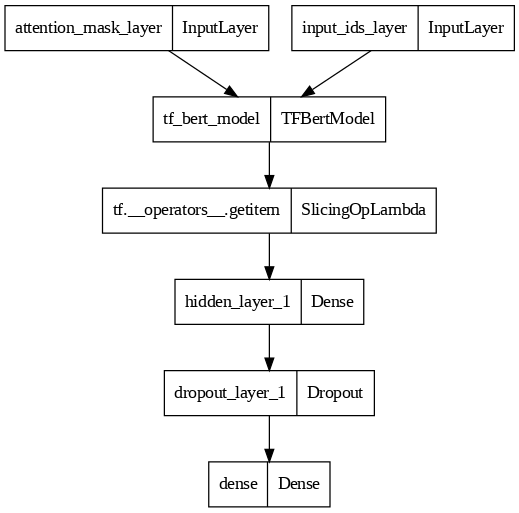

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 174s 420ms/step - loss: 0.9839 - MCRMSE: 0.9839 - val_loss: 0.5564 - val_MCRMSE: 0.5563
Epoch 2/10
391/391 [==============================] - 157s 403ms/step - loss: 0.6986 - MCRMSE: 0.6986 - val_loss: 0.5018 - val_MCRMSE: 0.5018
Epoch 3/10
391/391 [==============================] - 161s 412ms/step - loss: 0.6382 - MCRMSE: 0.6382 - val_loss: 0.4963 - val_MCRMSE: 0.4961
Epoch 4/10
391/391 [==============================] - 161s 411ms/step - loss: 0.6280 - MCRMSE: 0.6280 - val_loss: 0.4743 - val_MCRMSE: 0.4742
Epoch 5/10
391/391 [==============================] - 157s 401ms/step - loss: 0.6152 - MCRMSE: 0.6152 - val_loss: 0.4678 - val_MCRMSE: 0.4678
Epoch 6/10
391/391 [==============================] - 159s 407ms/step - loss: 0.6040 - MCRMSE: 0.6040 - val_loss: 0.4736 - val_MCRMSE: 0.4736
Epoch 7/10
391/391 [==============================] - 157s 401ms/step - loss: 0.5900 - MCRMSE: 0.5900 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,0.983941,0.698648,0.638181,0.628006,0.615215,0.603968,0.590027,0.583883,0.578687,0.574314
MCRMSE,0.983941,0.698648,0.638181,0.628006,0.615215,0.603968,0.590027,0.583883,0.578687,0.574314
val_loss,0.556385,0.501832,0.496285,0.474287,0.467800,0.473630,0.462185,0.461875,0.467112,0.454649
val_MCRMSE,0.556338,0.501808,0.496147,0.474212,0.467758,0.473583,0.462167,0.461867,0.467080,0.454655



Plotting loss and MCRMSE...


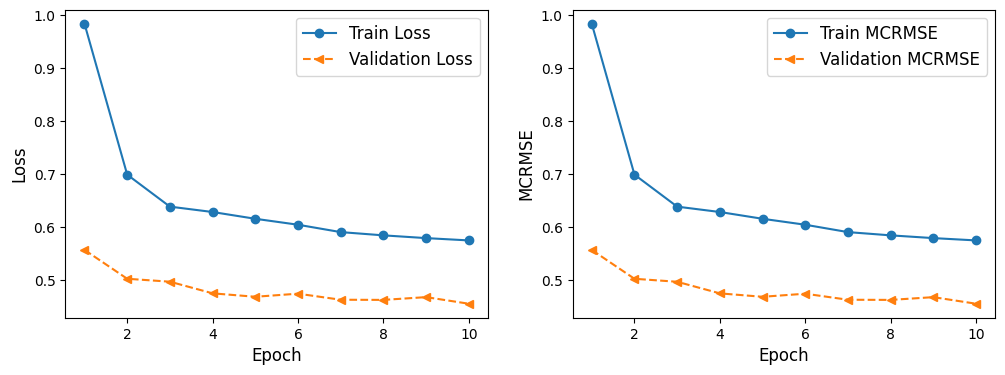

13/13 [==============================] - 16s 1s/step - loss: 0.4826 - MCRMSE: 0.4764

Evaluate Test Metrics:

Test loss: 0.4826

Test MCRMSE score: 0.4764 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

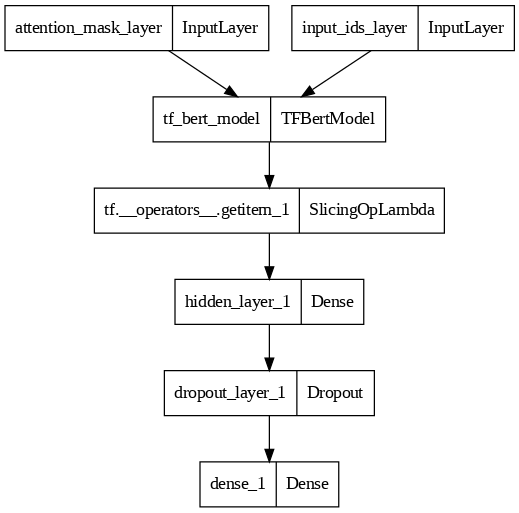

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 171s 423ms/step - loss: 1.1127 - MCRMSE: 1.1127 - val_loss: 0.5690 - val_MCRMSE: 0.5690
Epoch 2/10
391/391 [==============================] - 162s 413ms/step - loss: 0.7412 - MCRMSE: 0.7412 - val_loss: 0.5130 - val_MCRMSE: 0.5129
Epoch 3/10
391/391 [==============================] - 159s 407ms/step - loss: 0.6847 - MCRMSE: 0.6847 - val_loss: 0.5138 - val_MCRMSE: 0.5137
Epoch 4/10
391/391 [==============================] - 161s 411ms/step - loss: 0.6536 - MCRMSE: 0.6536 - val_loss: 0.4743 - val_MCRMSE: 0.4743
Epoch 5/10
391/391 [==============================] - 161s 412ms/step - loss: 0.6352 - MCRMSE: 0.6352 - val_loss: 0.4707 - val_MCRMSE: 0.4707
Epoch 6/10
391/391 [==============================] - 159s 407ms/step - loss: 0.6300 - MCRMSE: 0.6300 - val_loss: 0.4762 - val_MCRMSE: 0.4762
Epoch 7/10
391/391 [==============================] - 161s 411ms/step - loss: 0.6068 - MCRMSE: 0.6068 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.112710,0.741183,0.684658,0.653625,0.635188,0.630003,0.606769,0.597749,0.592456,0.586959
MCRMSE,1.112710,0.741183,0.684658,0.653625,0.635188,0.630003,0.606769,0.597749,0.592456,0.586959
val_loss,0.568986,0.512967,0.513786,0.474332,0.470683,0.476249,0.468342,0.472794,0.467645,0.457986
val_MCRMSE,0.568962,0.512942,0.513653,0.474299,0.470678,0.476217,0.468341,0.472777,0.467641,0.458024



Plotting loss and MCRMSE...


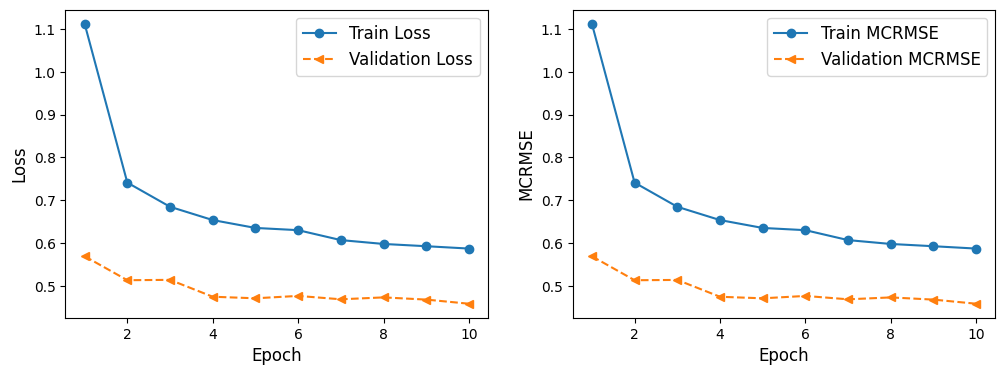

13/13 [==============================] - 16s 1s/step - loss: 0.4845 - MCRMSE: 0.4787

Evaluate Test Metrics:

Test loss: 0.4845

Test MCRMSE score: 0.4787 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

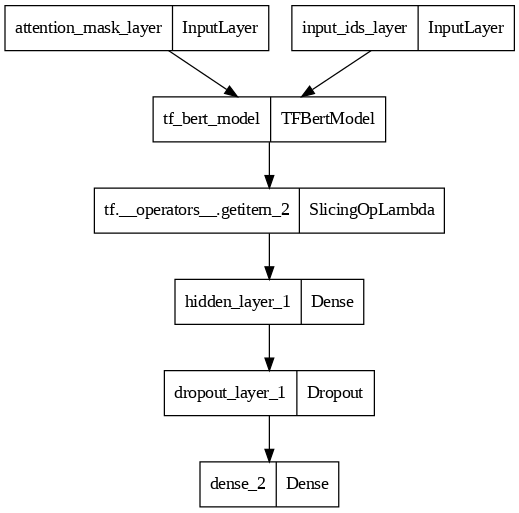

Training Regression with BERT.....
Epoch 1/10


391/391 [==============================] - 305s 722ms/step - loss: 0.7962 - MCRMSE: 0.7962 - val_loss: 0.4718 - val_MCRMSE: 0.4719
Epoch 2/10
391/391 [==============================] - 278s 712ms/step - loss: 0.6794 - MCRMSE: 0.6794 - val_loss: 0.4545 - val_MCRMSE: 0.4545
Epoch 3/10
391/391 [==============================] - 279s 713ms/step - loss: 0.6532 - MCRMSE: 0.6532 - val_loss: 0.4532 - val_MCRMSE: 0.4533
Epoch 4/10
391/391 [==============================] - 272s 696ms/step - loss: 0.6152 - MCRMSE: 0.6152 - val_loss: 0.4584 - val_MCRMSE: 0.4584
Epoch 5/10
391/391 [==============================] - 267s 684ms/step - loss: 0.5925 - MCRMSE: 0.5925 - val_loss: 0.4588 - val_MCRMSE: 0.4588
Epoch 6/10
391/391 [==============================] - 272s 695ms/step - loss: 0.5734 - MCRMSE: 0.5734 - val_loss: 0.4800 - val_MCRMSE: 0.4802
Epoch 7/10
391/391 [==============================] - 267s 683ms/step - loss: 0.5477 - MCRMSE: 0.5477 - val_loss: 0.4985 - val_MCRMSE: 0.4983
Epoch 8/10
391/39

,0,1,2,3,4,5,6,7,8,9
loss,0.796240,0.679424,0.653207,0.615197,0.592527,0.573405,0.547665,0.538007,0.520453,0.505778
MCRMSE,0.796240,0.679424,0.653207,0.615197,0.592527,0.573405,0.547665,0.538007,0.520453,0.505778
val_loss,0.471809,0.454518,0.453220,0.458424,0.458767,0.480012,0.498452,0.450406,0.458841,0.448243
val_MCRMSE,0.471890,0.454511,0.453271,0.458443,0.458800,0.480152,0.498275,0.450420,0.458909,0.448163



Plotting loss and MCRMSE...


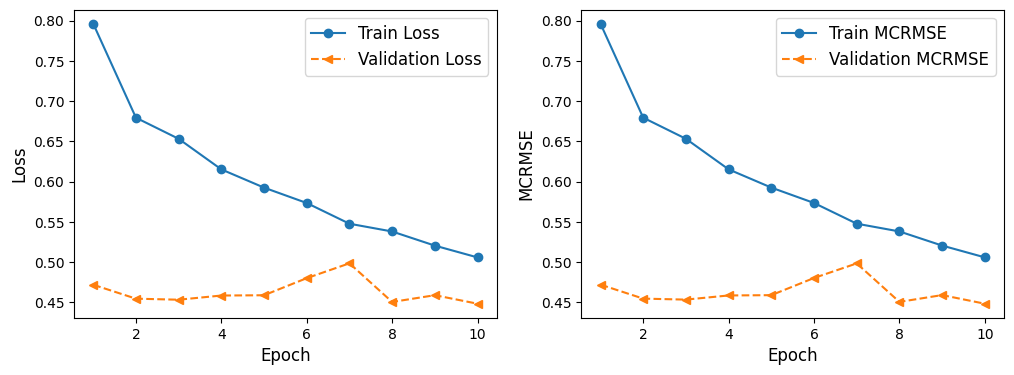

13/13 [==============================] - 16s 1s/step - loss: 0.4701 - MCRMSE: 0.4688

Evaluate Test Metrics:

Test loss: 0.4701

Test MCRMSE score: 0.4688 

13/13 [==============================] - 20s 1s/step


,NLP Model,Num_Trainable_layers,Trainable_Params,Non-Trainable_Params,Epochs,Test_MCRMSE,Test_Loss,Train_MCRMSE,Train_Loss,Val_MCRMSE,Val_Loss,Learning_Rate,Num_Hidden_Layers,Num_hidden_Units,Dropout,Batch_Size
0,bert-base-cased,0,"198,406","108,310,272",10,0.4764,0.4826,0.5743,0.5743,0.4547,0.4546,0.00005,1,256,0.3,8
1,bert-base-cased,6,"198,406","108,310,272",10,0.4787,0.4845,0.5870,0.5870,0.4580,0.4580,0.00005,1,256,0.3,8
2,bert-base-cased,12,"108,508,678",0,10,0.4688,0.4701,0.5058,0.5058,0.4482,0.4482,0.00005,1,256,0.3,8


In [ ]:
set_config_param(20230214)
run_regression_experiment(num_train_layers=np.arange(0,13,6),
                          activation='relu',
                          optimizer='adam',                          
                          csv_filename='perf_summary_regression_w_BERT_1.csv')

In [174]:
# set_config_param(1234)
# run_regression_experiment(num_train_layers=np.arange(0,13,6),
#                           epochs=3,         
#                           csv_filename='perf_summary_regression_w_BERT_RanSeed_2.csv')

In [673]:
# set_config_param(20230405)
# run_regression_experiment(num_train_layers=np.arange(0,13,6),
#                           csv_filename='perf_summary_regression_w_BERT_RanSeed_5.csv')

## Unfreeze 0, 2, 4, 6, 8, 10, or all 12 layers with:
- 2 hidden layers
- 64 hidden units
- 0.1 dropout
- 16 batch size


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                           

None

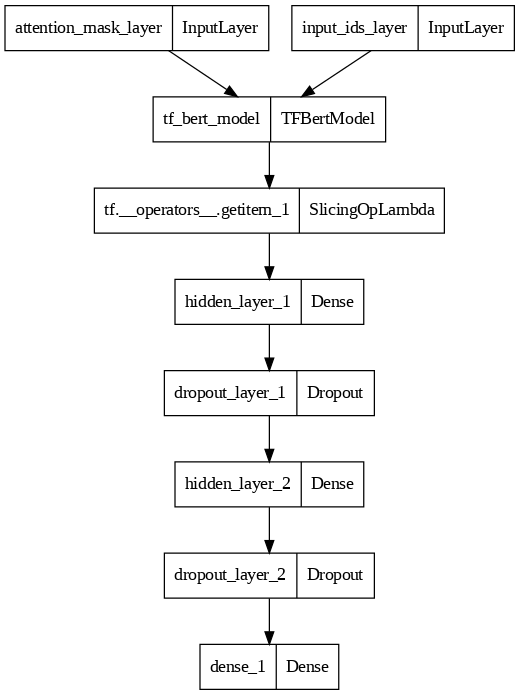

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 171s 818ms/step - loss: 2.9349 - MCRMSE: 2.9333 - val_loss: 2.7013 - val_MCRMSE: 2.7085
Epoch 2/10
196/196 [==============================] - 162s 826ms/step - loss: 2.5432 - MCRMSE: 2.5423 - val_loss: 2.2715 - val_MCRMSE: 2.2787
Epoch 3/10
196/196 [==============================] - 162s 828ms/step - loss: 2.0878 - MCRMSE: 2.0862 - val_loss: 1.6953 - val_MCRMSE: 1.7025
Epoch 4/10
196/196 [==============================] - 161s 824ms/step - loss: 1.5196 - MCRMSE: 1.5181 - val_loss: 1.0366 - val_MCRMSE: 1.0430
Epoch 5/10
196/196 [==============================] - 161s 824ms/step - loss: 1.1112 - MCRMSE: 1.1110 - val_loss: 0.6971 - val_MCRMSE: 0.7020
Epoch 6/10
196/196 [==============================] - 162s 825ms/step - loss: 0.9864 - MCRMSE: 0.9864 - val_loss: 0.6269 - val_MCRMSE: 0.6306
Epoch 7/10
196/196 [==============================] - 161s 823ms/step - loss: 0.9473 - MCRMSE: 0.9469 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,2.934896,2.543187,2.087789,1.519601,1.111196,0.986449,0.947293,0.920763,0.903362,0.896338
MCRMSE,2.933272,2.542295,2.086241,1.518090,1.111009,0.986384,0.946899,0.920293,0.903466,0.895929
val_loss,2.701277,2.271490,1.695254,1.036643,0.697137,0.626895,0.608230,0.599677,0.593473,0.588326
val_MCRMSE,2.708540,2.278693,1.702465,1.042957,0.702009,0.630642,0.611425,0.602432,0.596159,0.591028



Plotting loss and MCRMSE...


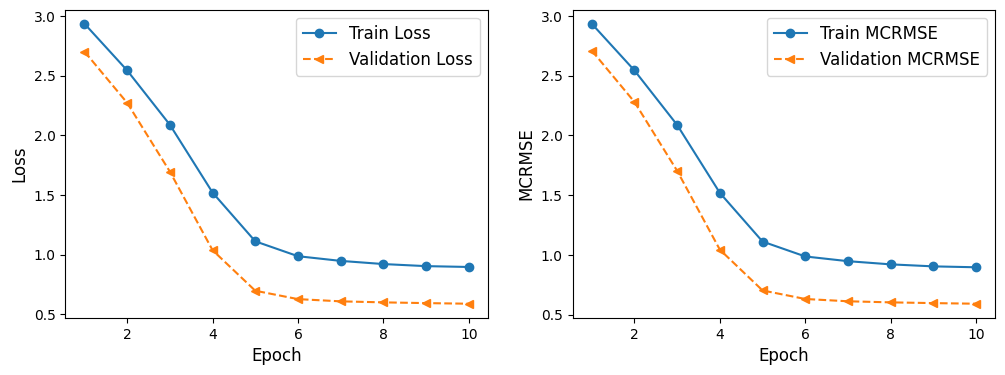

13/13 [==============================] - 15s 1s/step - loss: 0.6026 - MCRMSE: 0.6000

Evaluate Test Metrics:

Test loss: 0.6026

Test MCRMSE score: 0.6000 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 2
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

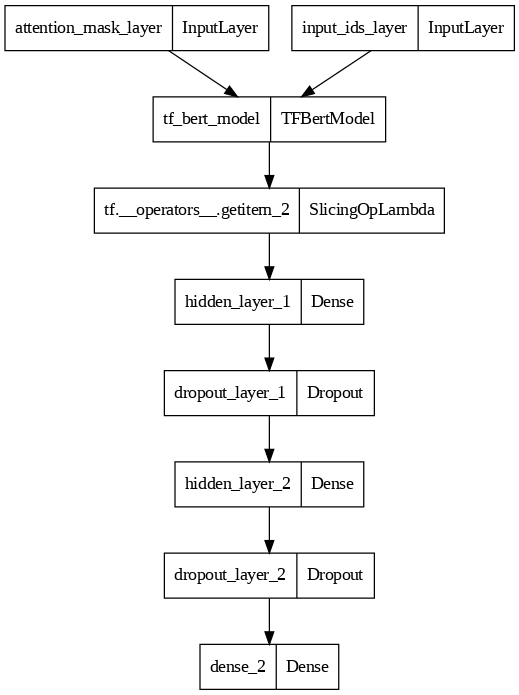

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 174s 844ms/step - loss: 3.3054 - MCRMSE: 3.3039 - val_loss: 3.0712 - val_MCRMSE: 3.0791
Epoch 2/10
196/196 [==============================] - 157s 800ms/step - loss: 2.8885 - MCRMSE: 2.8873 - val_loss: 2.5831 - val_MCRMSE: 2.5910
Epoch 3/10
196/196 [==============================] - 161s 824ms/step - loss: 2.3333 - MCRMSE: 2.3319 - val_loss: 1.8882 - val_MCRMSE: 1.8959
Epoch 4/10
196/196 [==============================] - 161s 824ms/step - loss: 1.6755 - MCRMSE: 1.6746 - val_loss: 1.1475 - val_MCRMSE: 1.1544
Epoch 5/10
196/196 [==============================] - 162s 825ms/step - loss: 1.1374 - MCRMSE: 1.1373 - val_loss: 0.7002 - val_MCRMSE: 0.7052
Epoch 6/10
196/196 [==============================] - 162s 826ms/step - loss: 0.9693 - MCRMSE: 0.9697 - val_loss: 0.6173 - val_MCRMSE: 0.6204
Epoch 7/10
196/196 [==============================] - 162s 825ms/step - loss: 0.9334 - MCRMSE: 0.9333 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,3.305440,2.888457,2.333335,1.675512,1.137419,0.969293,0.933405,0.920202,0.914304,0.898849
MCRMSE,3.303855,2.887313,2.331937,1.674564,1.137272,0.969744,0.933293,0.919728,0.914576,0.898332
val_loss,3.071232,2.583113,1.888204,1.147539,0.700242,0.617308,0.603697,0.594824,0.588670,0.581733
val_MCRMSE,3.079124,2.590951,1.895901,1.154415,0.705174,0.620381,0.606240,0.597057,0.590903,0.584119



Plotting loss and MCRMSE...


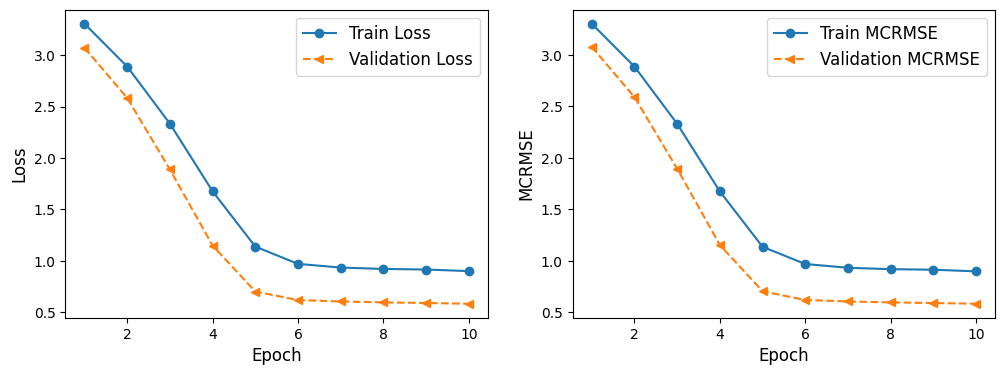

13/13 [==============================] - 15s 1s/step - loss: 0.5977 - MCRMSE: 0.5958

Evaluate Test Metrics:

Test loss: 0.5977

Test MCRMSE score: 0.5958 

13/13 [==============================] - 18s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 4
******************************************************

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

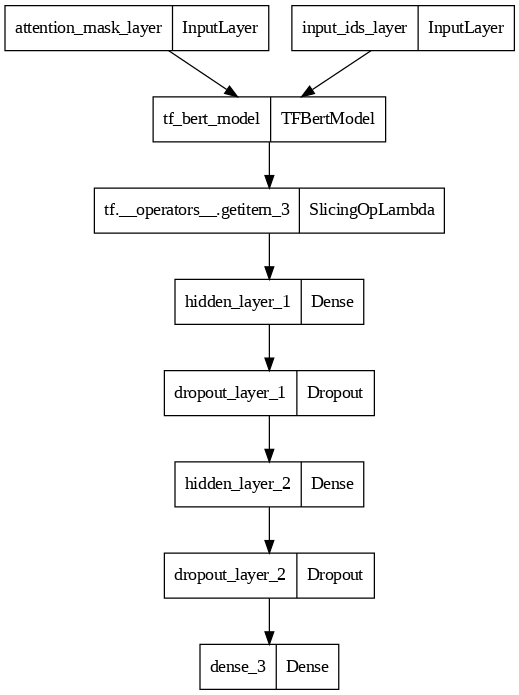

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 171s 830ms/step - loss: 2.9649 - MCRMSE: 2.9630 - val_loss: 2.6726 - val_MCRMSE: 2.6798
Epoch 2/10
196/196 [==============================] - 161s 822ms/step - loss: 2.5223 - MCRMSE: 2.5213 - val_loss: 2.2083 - val_MCRMSE: 2.2153
Epoch 3/10
196/196 [==============================] - 156s 798ms/step - loss: 2.0065 - MCRMSE: 2.0052 - val_loss: 1.5458 - val_MCRMSE: 1.5525
Epoch 4/10
196/196 [==============================] - 162s 825ms/step - loss: 1.4453 - MCRMSE: 1.4442 - val_loss: 0.9940 - val_MCRMSE: 0.9997
Epoch 5/10
196/196 [==============================] - 161s 823ms/step - loss: 1.1086 - MCRMSE: 1.1078 - val_loss: 0.6971 - val_MCRMSE: 0.7012
Epoch 6/10
196/196 [==============================] - 156s 797ms/step - loss: 0.9700 - MCRMSE: 0.9705 - val_loss: 0.6243 - val_MCRMSE: 0.6273
Epoch 7/10
196/196 [==============================] - 161s 823ms/step - loss: 0.9449 - MCRMSE: 0.9447 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,2.964889,2.522344,2.006521,1.445330,1.108551,0.970049,0.944899,0.918638,0.901881,0.894021
MCRMSE,2.963046,2.521271,2.005236,1.444160,1.107832,0.970471,0.944749,0.918228,0.901607,0.894033
val_loss,2.672610,2.208261,1.545826,0.994008,0.697078,0.624326,0.606530,0.596905,0.588881,0.582713
val_MCRMSE,2.679756,2.215309,1.552520,0.999694,0.701232,0.627348,0.609128,0.599117,0.590989,0.584820



Plotting loss and MCRMSE...


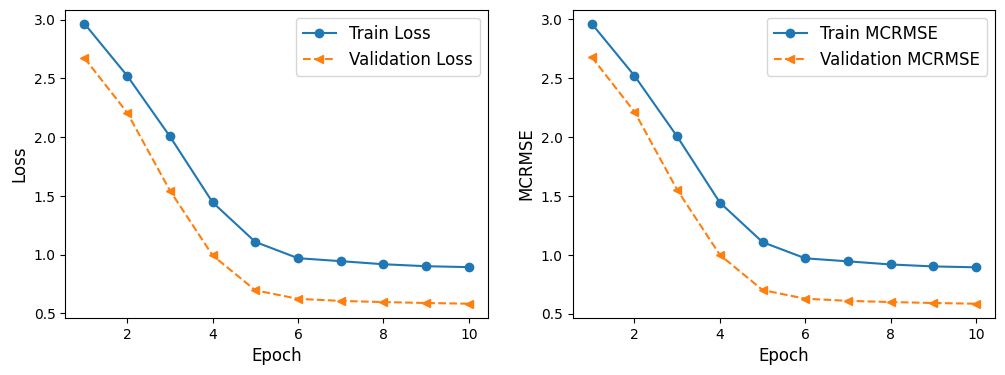

13/13 [==============================] - 15s 1s/step - loss: 0.6057 - MCRMSE: 0.6012

Evaluate Test Metrics:

Test loss: 0.6057

Test MCRMSE score: 0.6012 

13/13 [==============================] - 18s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

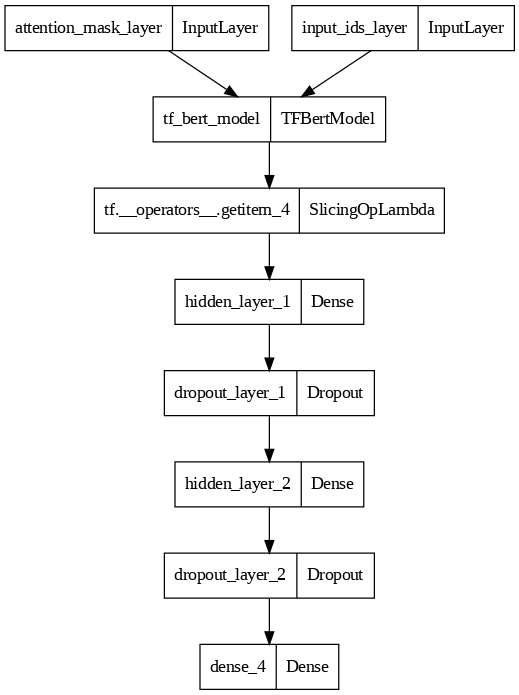

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 174s 843ms/step - loss: 2.6128 - MCRMSE: 2.6109 - val_loss: 2.2479 - val_MCRMSE: 2.2550
Epoch 2/10
196/196 [==============================] - 161s 822ms/step - loss: 1.8606 - MCRMSE: 1.8588 - val_loss: 1.3649 - val_MCRMSE: 1.3711
Epoch 3/10
196/196 [==============================] - 161s 822ms/step - loss: 1.1955 - MCRMSE: 1.1944 - val_loss: 0.7966 - val_MCRMSE: 0.8014
Epoch 4/10
196/196 [==============================] - 156s 794ms/step - loss: 0.9239 - MCRMSE: 0.9233 - val_loss: 0.6192 - val_MCRMSE: 0.6223
Epoch 5/10
196/196 [==============================] - 161s 822ms/step - loss: 0.8613 - MCRMSE: 0.8612 - val_loss: 0.5959 - val_MCRMSE: 0.5983
Epoch 6/10
196/196 [==============================] - 157s 801ms/step - loss: 0.8448 - MCRMSE: 0.8452 - val_loss: 0.5860 - val_MCRMSE: 0.5881
Epoch 7/10
196/196 [==============================] - 162s 824ms/step - loss: 0.8392 - MCRMSE: 0.8389 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,2.612775,1.860612,1.195475,0.923932,0.861267,0.844847,0.839157,0.813334,0.813864,0.804352
MCRMSE,2.610868,1.858789,1.194394,0.923255,0.861221,0.845235,0.838885,0.813199,0.814208,0.804408
val_loss,2.247867,1.364929,0.796637,0.619172,0.595866,0.586016,0.578426,0.569917,0.563357,0.555485
val_MCRMSE,2.254976,1.371145,0.801387,0.622265,0.598335,0.588138,0.580562,0.571717,0.564952,0.557087



Plotting loss and MCRMSE...


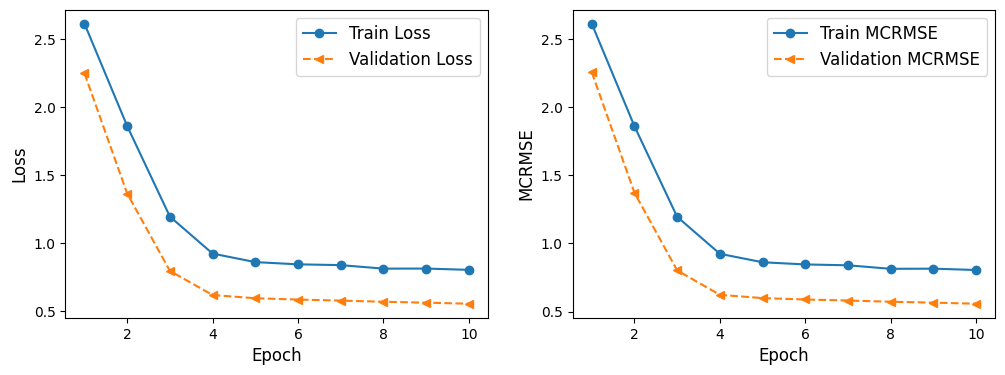

13/13 [==============================] - 15s 1s/step - loss: 0.5733 - MCRMSE: 0.5700

Evaluate Test Metrics:

Test loss: 0.5733

Test MCRMSE score: 0.5700 

13/13 [==============================] - 18s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 8
******************************************************

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

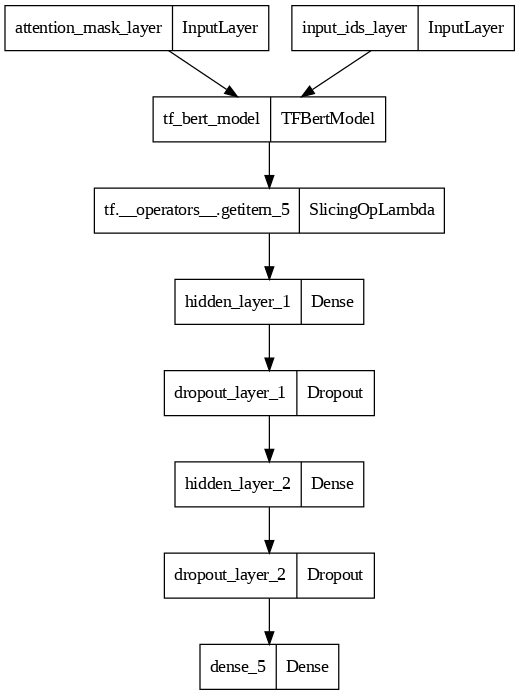

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 171s 828ms/step - loss: 3.1349 - MCRMSE: 3.1334 - val_loss: 2.9609 - val_MCRMSE: 2.9682
Epoch 2/10
196/196 [==============================] - 162s 825ms/step - loss: 2.8515 - MCRMSE: 2.8505 - val_loss: 2.6704 - val_MCRMSE: 2.6779
Epoch 3/10
196/196 [==============================] - 162s 826ms/step - loss: 2.5138 - MCRMSE: 2.5124 - val_loss: 2.2423 - val_MCRMSE: 2.2499
Epoch 4/10
196/196 [==============================] - 162s 825ms/step - loss: 2.0951 - MCRMSE: 2.0939 - val_loss: 1.7621 - val_MCRMSE: 1.7691
Epoch 5/10
196/196 [==============================] - 161s 824ms/step - loss: 1.6331 - MCRMSE: 1.6324 - val_loss: 1.2317 - val_MCRMSE: 1.2381
Epoch 6/10
196/196 [==============================] - 161s 824ms/step - loss: 1.2682 - MCRMSE: 1.2684 - val_loss: 0.8582 - val_MCRMSE: 0.8639
Epoch 7/10
196/196 [==============================] - 156s 798ms/step - loss: 1.0929 - MCRMSE: 1.0924 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,3.134858,2.851472,2.513797,2.095077,1.633149,1.268163,1.092941,1.020358,0.987379,0.981766
MCRMSE,3.133396,2.850497,2.512417,2.093857,1.632448,1.268394,1.092442,1.020167,0.987731,0.981554
val_loss,2.960899,2.670393,2.242331,1.762053,1.231715,0.858226,0.690279,0.636742,0.618446,0.613444
val_MCRMSE,2.968226,2.677921,2.249866,1.769109,1.238069,0.863922,0.695015,0.640643,0.621953,0.617041



Plotting loss and MCRMSE...


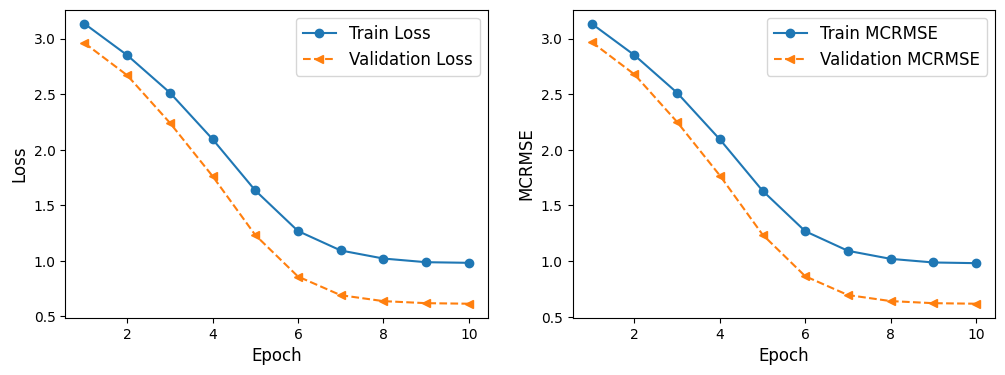

13/13 [==============================] - 15s 1s/step - loss: 0.6307 - MCRMSE: 0.6248

Evaluate Test Metrics:

Test loss: 0.6307

Test MCRMSE score: 0.6248 

13/13 [==============================] - 18s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 10
******************************************************

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

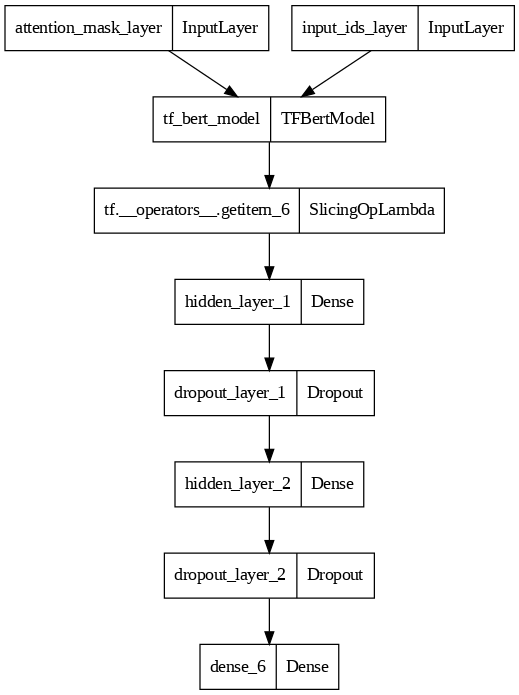

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 170s 817ms/step - loss: 2.9088 - MCRMSE: 2.9075 - val_loss: 2.6484 - val_MCRMSE: 2.6559
Epoch 2/10
196/196 [==============================] - 161s 824ms/step - loss: 2.3888 - MCRMSE: 2.3877 - val_loss: 1.9422 - val_MCRMSE: 1.9495
Epoch 3/10
196/196 [==============================] - 162s 826ms/step - loss: 1.6932 - MCRMSE: 1.6921 - val_loss: 1.1801 - val_MCRMSE: 1.1868
Epoch 4/10
196/196 [==============================] - 161s 823ms/step - loss: 1.1750 - MCRMSE: 1.1741 - val_loss: 0.7232 - val_MCRMSE: 0.7287
Epoch 5/10
196/196 [==============================] - 161s 823ms/step - loss: 1.0065 - MCRMSE: 1.0062 - val_loss: 0.6200 - val_MCRMSE: 0.6242
Epoch 6/10
196/196 [==============================] - 161s 822ms/step - loss: 0.9596 - MCRMSE: 0.9596 - val_loss: 0.6019 - val_MCRMSE: 0.6057
Epoch 7/10
196/196 [==============================] - 161s 823ms/step - loss: 0.9444 - MCRMSE: 0.9444 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,2.908845,2.388798,1.693218,1.175044,1.006473,0.959553,0.944352,0.921811,0.903077,0.893381
MCRMSE,2.907514,2.387726,1.692132,1.174090,1.006213,0.959623,0.944358,0.921699,0.902980,0.893114
val_loss,2.648366,1.942178,1.180070,0.723185,0.619995,0.601950,0.593247,0.583640,0.575800,0.569062
val_MCRMSE,2.655859,1.949514,1.186776,0.728743,0.624196,0.605683,0.596821,0.586850,0.578725,0.571971



Plotting loss and MCRMSE...


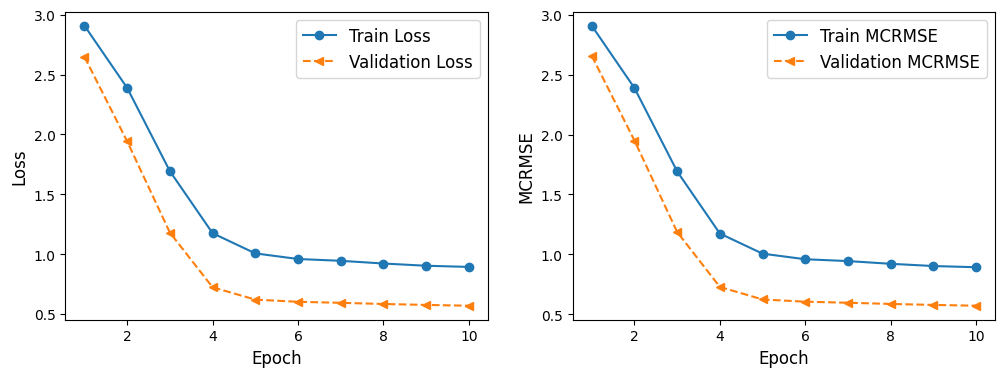

13/13 [==============================] - 15s 1s/step - loss: 0.5885 - MCRMSE: 0.5859

Evaluate Test Metrics:

Test loss: 0.5885

Test MCRMSE score: 0.5859 

13/13 [==============================] - 18s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

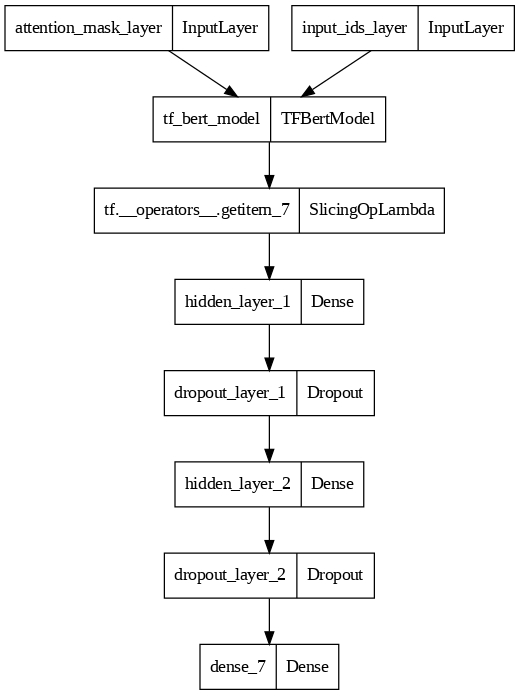

Training Regression with BERT.....
Epoch 1/10


196/196 [==============================] - 217s 1s/step - loss: 1.1983 - MCRMSE: 1.1971 - val_loss: 0.4925 - val_MCRMSE: 0.4929
Epoch 2/10
196/196 [==============================] - 200s 1s/step - loss: 0.8163 - MCRMSE: 0.8160 - val_loss: 0.4655 - val_MCRMSE: 0.4647
Epoch 3/10
196/196 [==============================] - 200s 1s/step - loss: 0.7859 - MCRMSE: 0.7861 - val_loss: 0.4487 - val_MCRMSE: 0.4484
Epoch 4/10
196/196 [==============================] - 195s 995ms/step - loss: 0.7710 - MCRMSE: 0.7704 - val_loss: 0.4467 - val_MCRMSE: 0.4472
Epoch 5/10
196/196 [==============================] - 193s 985ms/step - loss: 0.7464 - MCRMSE: 0.7460 - val_loss: 0.4505 - val_MCRMSE: 0.4511
Epoch 6/10
196/196 [==============================] - 200s 1s/step - loss: 0.7355 - MCRMSE: 0.7356 - val_loss: 0.4437 - val_MCRMSE: 0.4443
Epoch 7/10
196/196 [==============================] - 200s 1s/step - loss: 0.7347 - MCRMSE: 0.7351 - val_loss: 0.4409 - val_MCRMSE: 0.4419
Epoch 8/10
196/196 [============

,0,1,2,3,4,5,6,7,8,9
loss,1.198300,0.816349,0.785898,0.770988,0.746373,0.735467,0.734730,0.720499,0.709747,0.702606
MCRMSE,1.197116,0.815974,0.786078,0.770407,0.745978,0.735588,0.735079,0.720228,0.709871,0.702148
val_loss,0.492500,0.465507,0.448665,0.446659,0.450518,0.443652,0.440872,0.443815,0.437998,0.447828
val_MCRMSE,0.492901,0.464749,0.448389,0.447173,0.451111,0.444319,0.441891,0.444568,0.438392,0.449270



Plotting loss and MCRMSE...


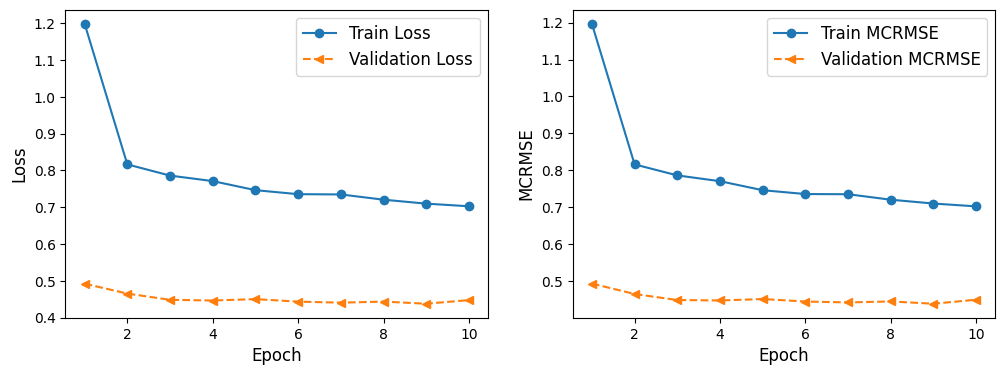

13/13 [==============================] - 15s 1s/step - loss: 0.4717 - MCRMSE: 0.4646

Evaluate Test Metrics:

Test loss: 0.4717

Test MCRMSE score: 0.4646 

13/13 [==============================] - 18s 1s/step


,NLP Model,Num_Trainable_layers,Trainable_Params,Non-Trainable_Params,Epochs,Test_MCRMSE,Test_Loss,Train_MCRMSE,Train_Loss,Val_MCRMSE,Val_Loss,Learning_Rate,Num_Hidden_Layers,Num_hidden_Units,Dropout,Batch_Size
0,bert-base-cased,0,"53,766","108,310,272",10,0.6000,0.6026,0.8959,0.8963,0.5910,0.5883,0.00001,2,64,0.1,16
1,bert-base-cased,2,"53,766","108,310,272",10,0.5958,0.5977,0.8983,0.8988,0.5841,0.5817,0.00001,2,64,0.1,16
2,bert-base-cased,4,"53,766","108,310,272",10,0.6012,0.6057,0.8940,0.8940,0.5848,0.5827,0.00001,2,64,0.1,16
3,bert-base-cased,6,"53,766","108,310,272",10,0.5700,0.5733,0.8044,0.8044,0.5571,0.5555,0.00001,2,64,0.1,16
4,bert-base-cased,8,"53,766","108,310,272",10,0.6248,0.6307,0.9816,0.9818,0.6170,0.6134,0.00001,2,64,0.1,16
5,bert-base-cased,10,"53,766","108,310,272",10,0.5859,0.5885,0.8931,0.8934,0.5720,0.5691,0.00001,2,64,0.1,16
6,bert-base-cased,12,"108,364,038",0,10,0.4646,0.4717,0.7021,0.7026,0.4493,0.4478,0.00001,2,64,0.1,16


In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,2),
                          num_hidden_layer=2,
                          num_hidden_units=64,
                          dropout=0.1,
                          learning_rate=0.00001,
                          batch_size=16,
                          csv_filename='perf_summary_regression_w_BERT_2.csv',
                          activation='relu',
                          optimizer='adam',
                          epochs=10)

In [839]:
# run_regression_experiment(num_train_layers=np.arange(0,13,2),
#                           num_hidden_layer=2,
#                           num_hidden_units=128,
#                           dropout=0.3,
#                           learning_rate=0.000001,
#                           batch_size=8,
#                           csv_filename='perf_summary_regression_w_BERT_3.csv')

## Unfreeze BERT layers of 0, 2, 4, 6, 8, 10, 12 with **batch size = 8**


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                             

None

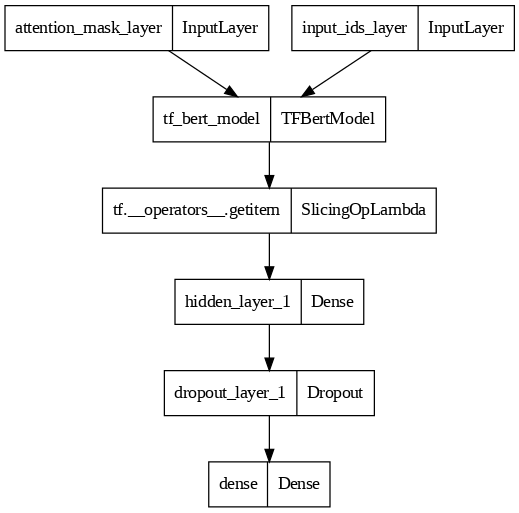

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 176s 429ms/step - loss: 1.0572 - MCRMSE: 1.0572 - val_loss: 0.5610 - val_MCRMSE: 0.5610
Epoch 2/10
391/391 [==============================] - 173s 443ms/step - loss: 0.7268 - MCRMSE: 0.7268 - val_loss: 0.5054 - val_MCRMSE: 0.5054
Epoch 3/10
391/391 [==============================] - 173s 442ms/step - loss: 0.6791 - MCRMSE: 0.6791 - val_loss: 0.4894 - val_MCRMSE: 0.4894
Epoch 4/10
391/391 [==============================] - 173s 441ms/step - loss: 0.6433 - MCRMSE: 0.6433 - val_loss: 0.4735 - val_MCRMSE: 0.4734
Epoch 5/10
391/391 [==============================] - 173s 442ms/step - loss: 0.6267 - MCRMSE: 0.6267 - val_loss: 0.4707 - val_MCRMSE: 0.4707
Epoch 6/10
391/391 [==============================] - 171s 436ms/step - loss: 0.6172 - MCRMSE: 0.6172 - val_loss: 0.4749 - val_MCRMSE: 0.4749
Epoch 7/10
391/391 [==============================] - 172s 440ms/step - loss: 0.5954 - MCRMSE: 0.5954 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.057224,0.726774,0.679065,0.643321,0.626676,0.617245,0.595443,0.592912,0.583259,0.574371
MCRMSE,1.057224,0.726774,0.679065,0.643321,0.626676,0.617245,0.595443,0.592912,0.583259,0.574371
val_loss,0.560978,0.505397,0.489437,0.473456,0.470717,0.474942,0.465315,0.466019,0.467815,0.459067
val_MCRMSE,0.560953,0.505402,0.489356,0.473395,0.470660,0.474873,0.465271,0.465984,0.467771,0.459049



Plotting loss and MCRMSE...


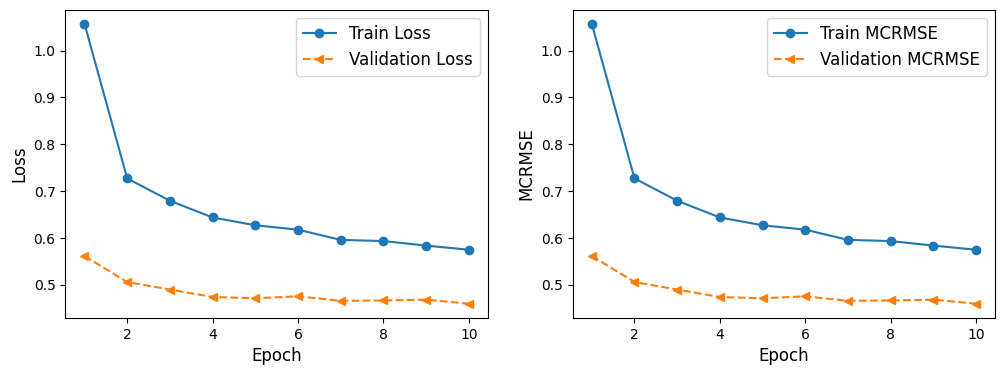

13/13 [==============================] - 18s 1s/step - loss: 0.4809 - MCRMSE: 0.4759

Evaluate Test Metrics:

Test loss: 0.4809

Test MCRMSE score: 0.4759 

13/13 [==============================] - 21s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 2
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

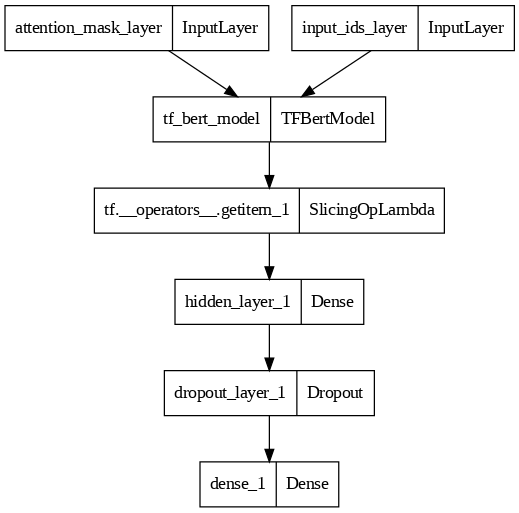

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 179s 443ms/step - loss: 1.1506 - MCRMSE: 1.1506 - val_loss: 0.5689 - val_MCRMSE: 0.5689
Epoch 2/10
391/391 [==============================] - 169s 432ms/step - loss: 0.7350 - MCRMSE: 0.7350 - val_loss: 0.5162 - val_MCRMSE: 0.5162
Epoch 3/10
391/391 [==============================] - 173s 441ms/step - loss: 0.6789 - MCRMSE: 0.6789 - val_loss: 0.4989 - val_MCRMSE: 0.4987
Epoch 4/10
391/391 [==============================] - 173s 443ms/step - loss: 0.6435 - MCRMSE: 0.6435 - val_loss: 0.4717 - val_MCRMSE: 0.4715
Epoch 5/10
391/391 [==============================] - 169s 433ms/step - loss: 0.6231 - MCRMSE: 0.6231 - val_loss: 0.4696 - val_MCRMSE: 0.4695
Epoch 6/10
391/391 [==============================] - 171s 436ms/step - loss: 0.6155 - MCRMSE: 0.6155 - val_loss: 0.4732 - val_MCRMSE: 0.4731
Epoch 7/10
391/391 [==============================] - 171s 436ms/step - loss: 0.6090 - MCRMSE: 0.6090 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.150605,0.734954,0.678879,0.643462,0.623052,0.615536,0.608992,0.596436,0.591157,0.582026
MCRMSE,1.150605,0.734954,0.678879,0.643462,0.623052,0.615536,0.608992,0.596436,0.591157,0.582026
val_loss,0.568890,0.516221,0.498886,0.471662,0.469618,0.473233,0.470650,0.469731,0.468982,0.459260
val_MCRMSE,0.568923,0.516188,0.498706,0.471511,0.469492,0.473091,0.470524,0.469641,0.468883,0.459182



Plotting loss and MCRMSE...


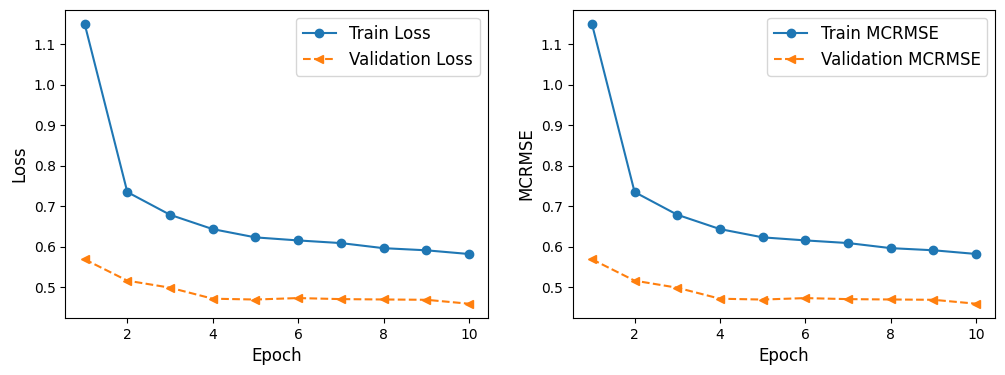

13/13 [==============================] - 17s 1s/step - loss: 0.4887 - MCRMSE: 0.4840

Evaluate Test Metrics:

Test loss: 0.4887

Test MCRMSE score: 0.4840 

13/13 [==============================] - 22s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 4
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

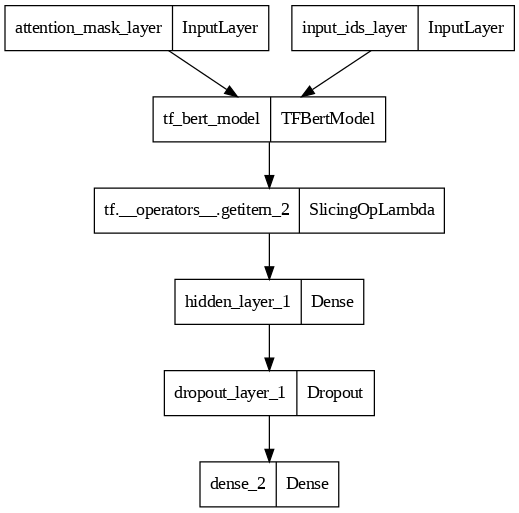

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 181s 452ms/step - loss: 1.0166 - MCRMSE: 1.0166 - val_loss: 0.5581 - val_MCRMSE: 0.5580
Epoch 2/10
391/391 [==============================] - 173s 443ms/step - loss: 0.7108 - MCRMSE: 0.7108 - val_loss: 0.5014 - val_MCRMSE: 0.5014
Epoch 3/10
391/391 [==============================] - 172s 441ms/step - loss: 0.6531 - MCRMSE: 0.6531 - val_loss: 0.4960 - val_MCRMSE: 0.4959
Epoch 4/10
391/391 [==============================] - 169s 433ms/step - loss: 0.6282 - MCRMSE: 0.6282 - val_loss: 0.4749 - val_MCRMSE: 0.4748
Epoch 5/10
391/391 [==============================] - 173s 441ms/step - loss: 0.6146 - MCRMSE: 0.6146 - val_loss: 0.4715 - val_MCRMSE: 0.4715
Epoch 6/10
391/391 [==============================] - 171s 437ms/step - loss: 0.6121 - MCRMSE: 0.6121 - val_loss: 0.4787 - val_MCRMSE: 0.4786
Epoch 7/10
391/391 [==============================] - 172s 441ms/step - loss: 0.5945 - MCRMSE: 0.5945 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.016626,0.710811,0.653068,0.628153,0.614561,0.612078,0.594466,0.583707,0.585549,0.572005
MCRMSE,1.016626,0.710811,0.653068,0.628153,0.614561,0.612078,0.594466,0.583707,0.585549,0.572005
val_loss,0.558109,0.501439,0.495995,0.474919,0.471487,0.478680,0.466912,0.476321,0.482624,0.466511
val_MCRMSE,0.558040,0.501381,0.495859,0.474844,0.471469,0.478634,0.466915,0.476295,0.482584,0.466478



Plotting loss and MCRMSE...


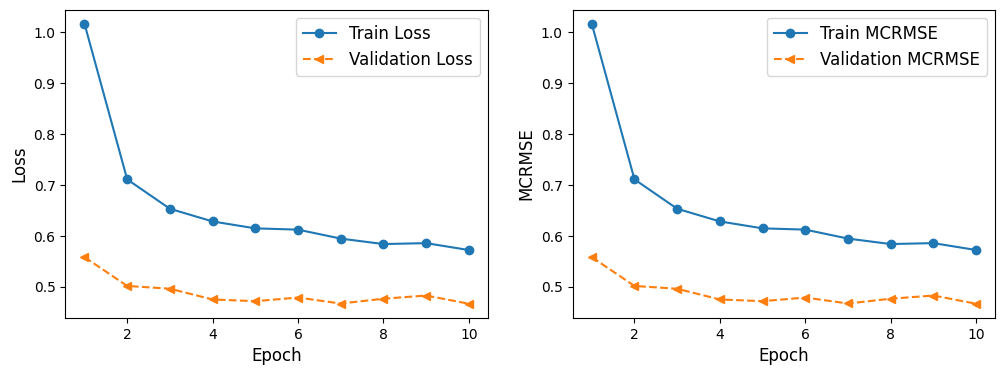

13/13 [==============================] - 17s 1s/step - loss: 0.4892 - MCRMSE: 0.4845

Evaluate Test Metrics:

Test loss: 0.4892

Test MCRMSE score: 0.4845 

13/13 [==============================] - 21s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

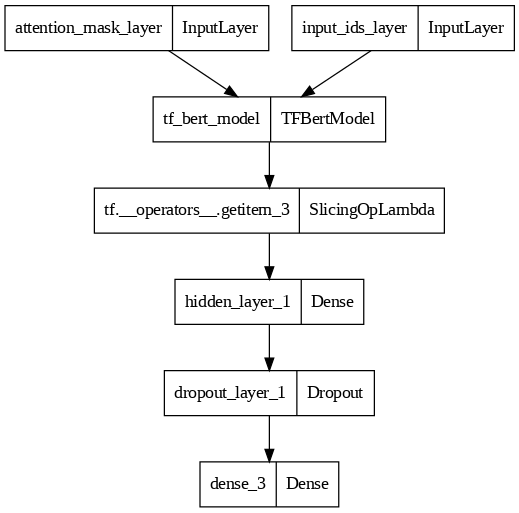

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 181s 448ms/step - loss: 1.0518 - MCRMSE: 1.0518 - val_loss: 0.5622 - val_MCRMSE: 0.5623
Epoch 2/10
391/391 [==============================] - 173s 442ms/step - loss: 0.7269 - MCRMSE: 0.7269 - val_loss: 0.5124 - val_MCRMSE: 0.5124
Epoch 3/10
391/391 [==============================] - 170s 434ms/step - loss: 0.6690 - MCRMSE: 0.6690 - val_loss: 0.4987 - val_MCRMSE: 0.4986
Epoch 4/10
391/391 [==============================] - 169s 433ms/step - loss: 0.6381 - MCRMSE: 0.6381 - val_loss: 0.4750 - val_MCRMSE: 0.4750
Epoch 5/10
391/391 [==============================] - 173s 441ms/step - loss: 0.6205 - MCRMSE: 0.6205 - val_loss: 0.4736 - val_MCRMSE: 0.4736
Epoch 6/10
391/391 [==============================] - 171s 436ms/step - loss: 0.6109 - MCRMSE: 0.6109 - val_loss: 0.4755 - val_MCRMSE: 0.4755
Epoch 7/10
391/391 [==============================] - 169s 432ms/step - loss: 0.5952 - MCRMSE: 0.5952 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.051783,0.726945,0.668982,0.638124,0.620527,0.610932,0.595205,0.588692,0.583954,0.569291
MCRMSE,1.051783,0.726945,0.668982,0.638124,0.620527,0.610932,0.595205,0.588692,0.583954,0.569291
val_loss,0.562186,0.512408,0.498709,0.475004,0.473609,0.475545,0.467700,0.463109,0.465702,0.466068
val_MCRMSE,0.562271,0.512441,0.498625,0.474958,0.473585,0.475517,0.467677,0.463111,0.465682,0.466039



Plotting loss and MCRMSE...


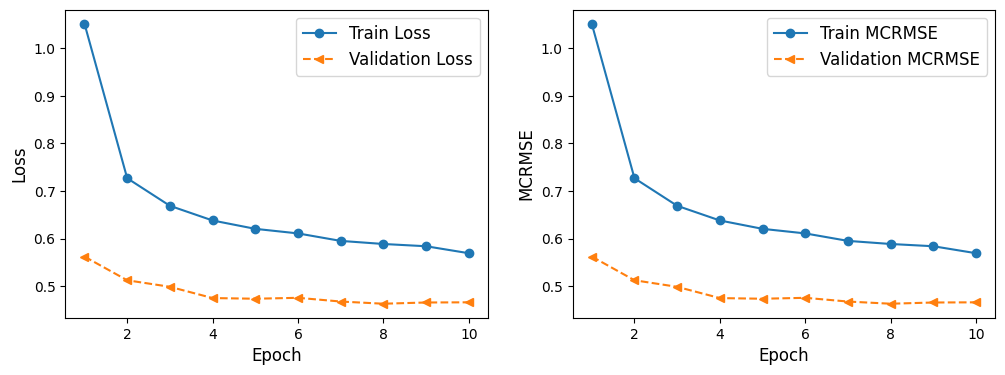

13/13 [==============================] - 17s 1s/step - loss: 0.4872 - MCRMSE: 0.4826

Evaluate Test Metrics:

Test loss: 0.4872

Test MCRMSE score: 0.4826 

13/13 [==============================] - 21s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 8
******************************************************

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

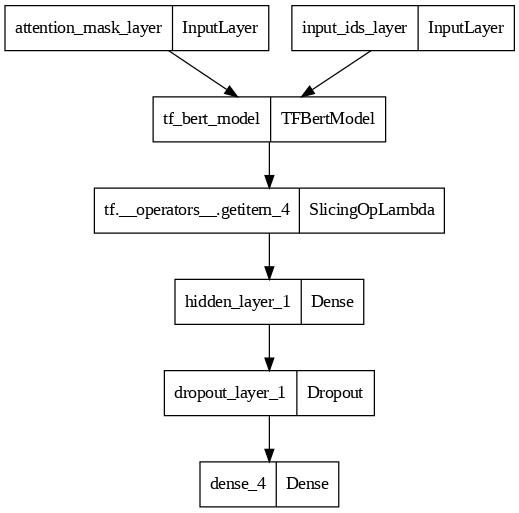

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 178s 440ms/step - loss: 1.0206 - MCRMSE: 1.0206 - val_loss: 0.5591 - val_MCRMSE: 0.5590
Epoch 2/10
391/391 [==============================] - 172s 441ms/step - loss: 0.7080 - MCRMSE: 0.7080 - val_loss: 0.4979 - val_MCRMSE: 0.4978
Epoch 3/10
391/391 [==============================] - 171s 436ms/step - loss: 0.6549 - MCRMSE: 0.6549 - val_loss: 0.5068 - val_MCRMSE: 0.5067
Epoch 4/10
391/391 [==============================] - 172s 441ms/step - loss: 0.6275 - MCRMSE: 0.6275 - val_loss: 0.4728 - val_MCRMSE: 0.4728
Epoch 5/10
391/391 [==============================] - 169s 432ms/step - loss: 0.6156 - MCRMSE: 0.6156 - val_loss: 0.4684 - val_MCRMSE: 0.4684
Epoch 6/10
391/391 [==============================] - 171s 437ms/step - loss: 0.6062 - MCRMSE: 0.6062 - val_loss: 0.4800 - val_MCRMSE: 0.4800
Epoch 7/10
391/391 [==============================] - 171s 436ms/step - loss: 0.5946 - MCRMSE: 0.5946 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.020629,0.707984,0.654945,0.627548,0.615556,0.606242,0.594594,0.591003,0.579664,0.578493
MCRMSE,1.020629,0.707984,0.654945,0.627548,0.615556,0.606242,0.594594,0.591003,0.579664,0.578493
val_loss,0.559134,0.497864,0.506829,0.472839,0.468379,0.479984,0.472278,0.466815,0.464788,0.459642
val_MCRMSE,0.559021,0.497842,0.506671,0.472815,0.468398,0.479951,0.472269,0.466830,0.464798,0.459684



Plotting loss and MCRMSE...


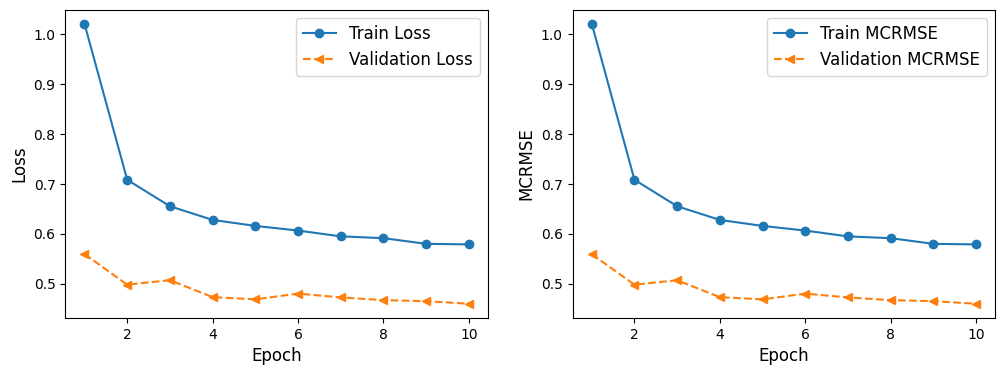

13/13 [==============================] - 17s 1s/step - loss: 0.4820 - MCRMSE: 0.4766

Evaluate Test Metrics:

Test loss: 0.4820

Test MCRMSE score: 0.4766 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 10
******************************************************

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

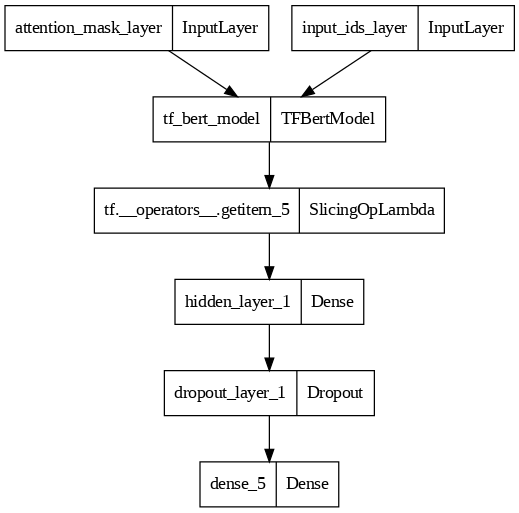

Training Regression with BERT.....
Epoch 1/10
391/391 [==============================] - 180s 444ms/step - loss: 0.9529 - MCRMSE: 0.9529 - val_loss: 0.5528 - val_MCRMSE: 0.5528
Epoch 2/10
391/391 [==============================] - 173s 443ms/step - loss: 0.6974 - MCRMSE: 0.6974 - val_loss: 0.4980 - val_MCRMSE: 0.4980
Epoch 3/10
391/391 [==============================] - 169s 433ms/step - loss: 0.6543 - MCRMSE: 0.6543 - val_loss: 0.4933 - val_MCRMSE: 0.4932
Epoch 4/10
391/391 [==============================] - 173s 443ms/step - loss: 0.6220 - MCRMSE: 0.6220 - val_loss: 0.4743 - val_MCRMSE: 0.4742
Epoch 5/10
391/391 [==============================] - 173s 442ms/step - loss: 0.6143 - MCRMSE: 0.6143 - val_loss: 0.4653 - val_MCRMSE: 0.4654
Epoch 6/10
391/391 [==============================] - 171s 436ms/step - loss: 0.6035 - MCRMSE: 0.6035 - val_loss: 0.4814 - val_MCRMSE: 0.4813
Epoch 7/10
391/391 [==============================] - 172s 441ms/step - loss: 0.5923 - MCRMSE: 0.5923 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,0.952873,0.697384,0.654255,0.621950,0.614316,0.603480,0.592286,0.587319,0.583173,0.577734
MCRMSE,0.952873,0.697384,0.654255,0.621950,0.614316,0.603480,0.592286,0.587319,0.583173,0.577734
val_loss,0.552838,0.498010,0.493332,0.474270,0.465338,0.481371,0.460171,0.465180,0.469337,0.458866
val_MCRMSE,0.552753,0.497970,0.493216,0.474228,0.465354,0.481321,0.460186,0.465185,0.469309,0.458889



Plotting loss and MCRMSE...


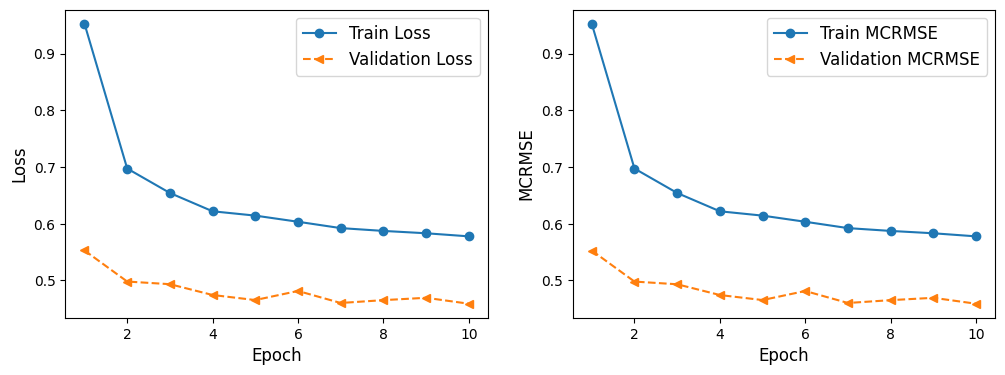

13/13 [==============================] - 17s 1s/step - loss: 0.4856 - MCRMSE: 0.4798

Evaluate Test Metrics:

Test loss: 0.4856

Test MCRMSE score: 0.4798 

13/13 [==============================] - 21s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

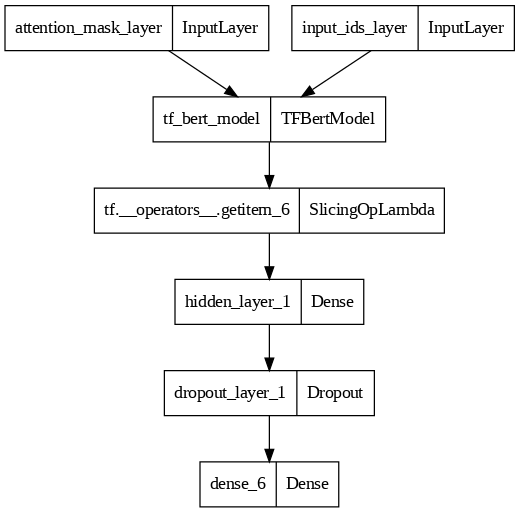

Training Regression with BERT.....
Epoch 1/10


391/391 [==============================] - 228s 555ms/step - loss: 0.7389 - MCRMSE: 0.7389 - val_loss: 0.4643 - val_MCRMSE: 0.4642
Epoch 2/10
391/391 [==============================] - 211s 540ms/step - loss: 0.6464 - MCRMSE: 0.6464 - val_loss: 0.4614 - val_MCRMSE: 0.4614
Epoch 3/10
391/391 [==============================] - 215s 549ms/step - loss: 0.6176 - MCRMSE: 0.6176 - val_loss: 0.4494 - val_MCRMSE: 0.4494
Epoch 4/10
391/391 [==============================] - 208s 531ms/step - loss: 0.6051 - MCRMSE: 0.6051 - val_loss: 0.4499 - val_MCRMSE: 0.4499
Epoch 5/10
391/391 [==============================] - 204s 522ms/step - loss: 0.5904 - MCRMSE: 0.5904 - val_loss: 0.4529 - val_MCRMSE: 0.4530
Epoch 6/10
391/391 [==============================] - 214s 547ms/step - loss: 0.5779 - MCRMSE: 0.5779 - val_loss: 0.4408 - val_MCRMSE: 0.4409
Epoch 7/10
391/391 [==============================] - 208s 531ms/step - loss: 0.5626 - MCRMSE: 0.5626 - val_loss: 0.4457 - val_MCRMSE: 0.4459
Epoch 8/10
391/39

,0,1,2,3,4,5,6,7,8,9
loss,0.738904,0.646425,0.617643,0.605098,0.590422,0.577922,0.562631,0.552224,0.538682,0.523107
MCRMSE,0.738904,0.646425,0.617643,0.605098,0.590422,0.577922,0.562631,0.552224,0.538682,0.523107
val_loss,0.464275,0.461372,0.449441,0.449889,0.452915,0.440771,0.445737,0.448443,0.450247,0.514751
val_MCRMSE,0.464231,0.461412,0.449433,0.449903,0.452956,0.440863,0.445899,0.448676,0.450293,0.514734



Plotting loss and MCRMSE...


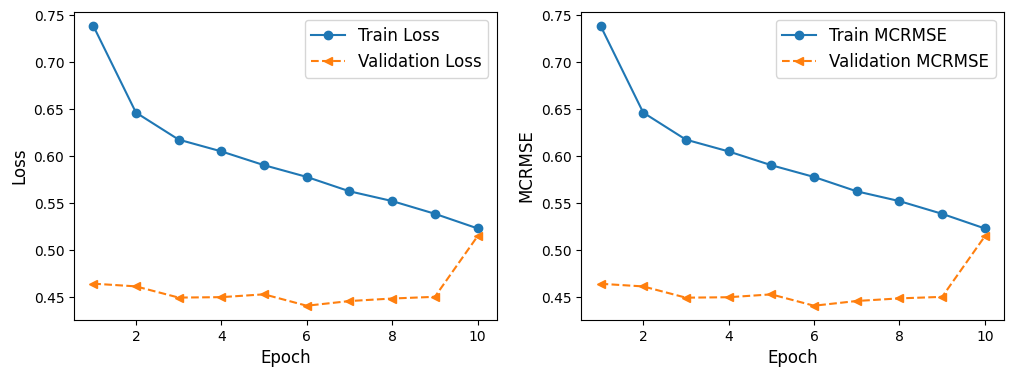

13/13 [==============================] - 17s 1s/step - loss: 0.5200 - MCRMSE: 0.5192

Evaluate Test Metrics:

Test loss: 0.5200

Test MCRMSE score: 0.5192 

13/13 [==============================] - 21s 1s/step


,NLP Model,Num_Trainable_layers,Trainable_Params,Non-Trainable_Params,Epochs,Test_MCRMSE,Test_Loss,Train_MCRMSE,Train_Loss,Val_MCRMSE,Val_Loss,Learning_Rate,Num_Hidden_Layers,Num_hidden_Units,Dropout,Batch_Size
0,bert-base-cased,0,"198,406","108,310,272",10,0.4759,0.4809,0.5744,0.5744,0.4590,0.4591,0.00005,1,256,0.3,8
1,bert-base-cased,2,"198,406","108,310,272",10,0.4840,0.4887,0.5820,0.5820,0.4592,0.4593,0.00005,1,256,0.3,8
2,bert-base-cased,4,"198,406","108,310,272",10,0.4845,0.4892,0.5720,0.5720,0.4665,0.4665,0.00005,1,256,0.3,8
3,bert-base-cased,6,"198,406","108,310,272",10,0.4826,0.4872,0.5693,0.5693,0.4660,0.4661,0.00005,1,256,0.3,8
4,bert-base-cased,8,"198,406","108,310,272",10,0.4766,0.4820,0.5785,0.5785,0.4597,0.4596,0.00005,1,256,0.3,8
5,bert-base-cased,10,"198,406","108,310,272",10,0.4798,0.4856,0.5777,0.5777,0.4589,0.4589,0.00005,1,256,0.3,8
6,bert-base-cased,12,"108,508,678",0,10,0.5192,0.5200,0.5231,0.5231,0.5147,0.5148,0.00005,1,256,0.3,8


In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,2),
                          csv_filename='perf_summary_regression_w_BERT_5.csv')

## **Learning rate = 0.00005** with **batch size = 16** and **activation = 'relu'**


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                           

None

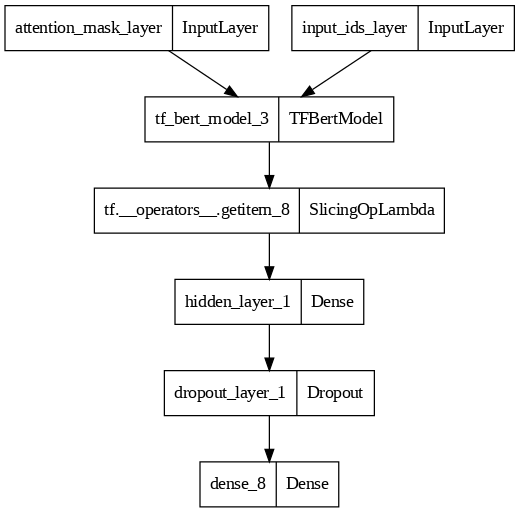

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 178s 838ms/step - loss: 1.3027 - MCRMSE: 1.3010 - val_loss: 0.5881 - val_MCRMSE: 0.5869
Epoch 2/10
196/196 [==============================] - 165s 842ms/step - loss: 0.7769 - MCRMSE: 0.7767 - val_loss: 0.5483 - val_MCRMSE: 0.5475
Epoch 3/10
196/196 [==============================] - 165s 843ms/step - loss: 0.7206 - MCRMSE: 0.7207 - val_loss: 0.5197 - val_MCRMSE: 0.5190
Epoch 4/10
196/196 [==============================] - 165s 841ms/step - loss: 0.6781 - MCRMSE: 0.6779 - val_loss: 0.5091 - val_MCRMSE: 0.5086
Epoch 5/10
196/196 [==============================] - 165s 841ms/step - loss: 0.6552 - MCRMSE: 0.6551 - val_loss: 0.4989 - val_MCRMSE: 0.4985
Epoch 6/10
196/196 [==============================] - 160s 817ms/step - loss: 0.6289 - MCRMSE: 0.6290 - val_loss: 0.4952 - val_MCRMSE: 0.4953
Epoch 7/10
196/196 [==============================] - 160s 816ms/step - loss: 0.6241 - MCRMSE: 0.6240 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.302655,0.776895,0.720568,0.678072,0.655221,0.628893,0.624097,0.614837,0.603122,0.595849
MCRMSE,1.301047,0.776708,0.720707,0.677938,0.655132,0.629002,0.624032,0.615142,0.603154,0.595855
val_loss,0.588121,0.548295,0.519688,0.509070,0.498890,0.495216,0.490829,0.485106,0.503884,0.481056
val_MCRMSE,0.586923,0.547479,0.519013,0.508590,0.498492,0.495262,0.490724,0.485250,0.504901,0.481367



Plotting loss and MCRMSE...


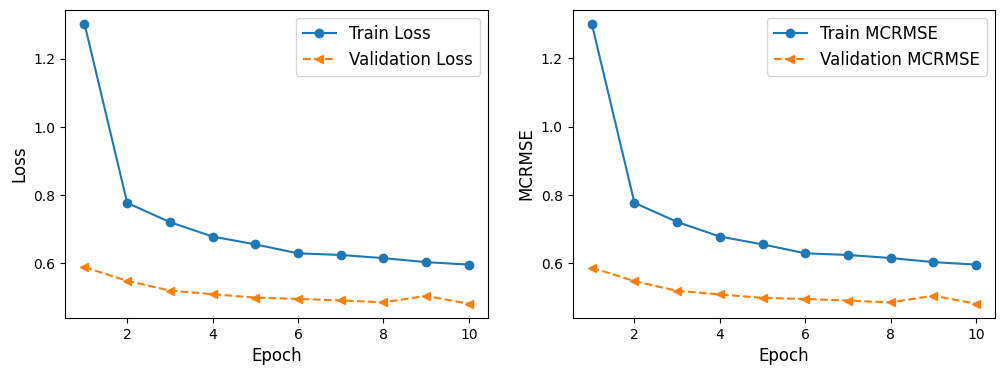

13/13 [==============================] - 16s 1s/step - loss: 0.4860 - MCRMSE: 0.4827

Evaluate Test Metrics:

Test loss: 0.4860

Test MCRMSE score: 0.4827 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

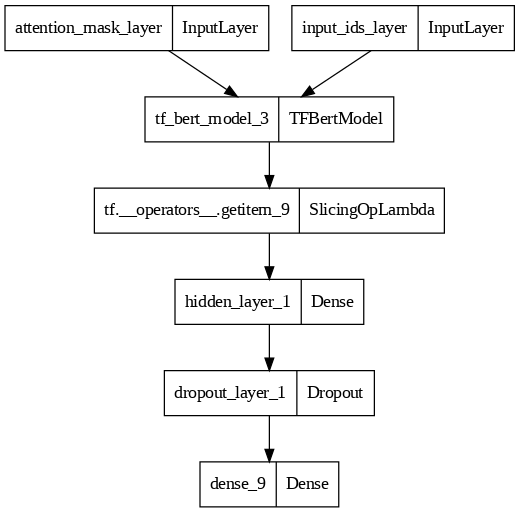

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 178s 855ms/step - loss: 1.0668 - MCRMSE: 1.0662 - val_loss: 0.5829 - val_MCRMSE: 0.5820
Epoch 2/10
196/196 [==============================] - 165s 842ms/step - loss: 0.7543 - MCRMSE: 0.7542 - val_loss: 0.5379 - val_MCRMSE: 0.5376
Epoch 3/10
196/196 [==============================] - 165s 840ms/step - loss: 0.7017 - MCRMSE: 0.7014 - val_loss: 0.5142 - val_MCRMSE: 0.5142
Epoch 4/10
196/196 [==============================] - 165s 840ms/step - loss: 0.6620 - MCRMSE: 0.6616 - val_loss: 0.4989 - val_MCRMSE: 0.4990
Epoch 5/10
196/196 [==============================] - 165s 841ms/step - loss: 0.6427 - MCRMSE: 0.6426 - val_loss: 0.4878 - val_MCRMSE: 0.4878
Epoch 6/10
196/196 [==============================] - 163s 831ms/step - loss: 0.6276 - MCRMSE: 0.6274 - val_loss: 0.4920 - val_MCRMSE: 0.4926
Epoch 7/10
196/196 [==============================] - 165s 840ms/step - loss: 0.6189 - MCRMSE: 0.6188 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.066849,0.754315,0.701708,0.662042,0.642722,0.627568,0.618888,0.605120,0.596188,0.595106
MCRMSE,1.066186,0.754207,0.701434,0.661619,0.642644,0.627378,0.618800,0.604987,0.595788,0.595100
val_loss,0.582896,0.537910,0.514240,0.498895,0.487782,0.492019,0.478907,0.475434,0.481514,0.473228
val_MCRMSE,0.582010,0.537616,0.514194,0.499032,0.487830,0.492568,0.479317,0.475616,0.482408,0.473574



Plotting loss and MCRMSE...


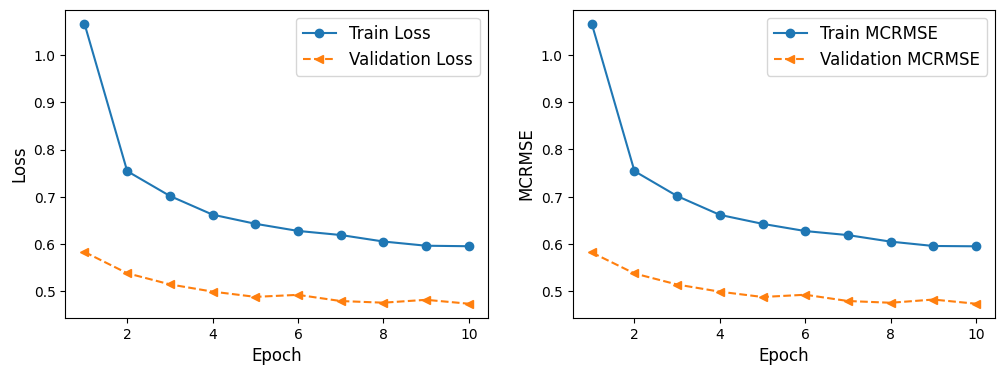

13/13 [==============================] - 16s 1s/step - loss: 0.4789 - MCRMSE: 0.4752

Evaluate Test Metrics:

Test loss: 0.4789

Test MCRMSE score: 0.4752 

13/13 [==============================] - 22s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
             

None

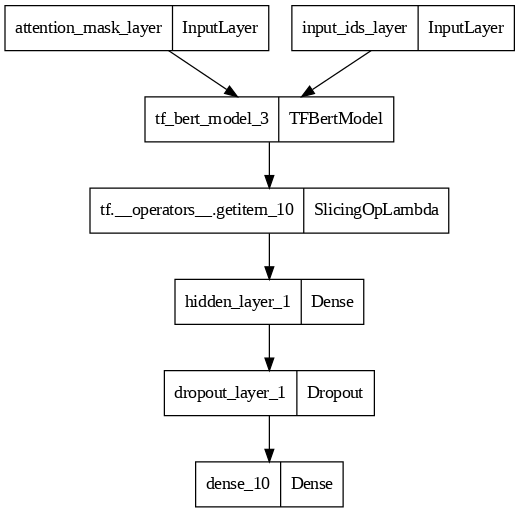

Training Regression with BERT.....
Epoch 1/10


196/196 [==============================] - 308s 1s/step - loss: 0.7579 - MCRMSE: 0.7581 - val_loss: 0.5322 - val_MCRMSE: 0.5363
Epoch 2/10
196/196 [==============================] - 279s 1s/step - loss: 0.6495 - MCRMSE: 0.6492 - val_loss: 0.4497 - val_MCRMSE: 0.4499
Epoch 3/10
196/196 [==============================] - 272s 1s/step - loss: 0.6232 - MCRMSE: 0.6231 - val_loss: 0.4634 - val_MCRMSE: 0.4661
Epoch 4/10
196/196 [==============================] - 275s 1s/step - loss: 0.6053 - MCRMSE: 0.6049 - val_loss: 0.4463 - val_MCRMSE: 0.4469
Epoch 5/10
196/196 [==============================] - 272s 1s/step - loss: 0.5938 - MCRMSE: 0.5938 - val_loss: 0.4568 - val_MCRMSE: 0.4563
Epoch 6/10
196/196 [==============================] - 272s 1s/step - loss: 0.5678 - MCRMSE: 0.5678 - val_loss: 0.4505 - val_MCRMSE: 0.4519
Epoch 7/10
196/196 [==============================] - 272s 1s/step - loss: 0.5495 - MCRMSE: 0.5496 - val_loss: 0.4794 - val_MCRMSE: 0.4817
Epoch 8/10
196/196 [==================

,0,1,2,3,4,5,6,7,8,9
loss,0.757895,0.649477,0.623220,0.605276,0.593828,0.567777,0.549523,0.531401,0.521677,0.509407
MCRMSE,0.758115,0.649231,0.623134,0.604943,0.593760,0.567808,0.549608,0.531475,0.521503,0.509126
val_loss,0.532243,0.449742,0.463382,0.446280,0.456797,0.450507,0.479417,0.449861,0.470952,0.465608
val_MCRMSE,0.536269,0.449879,0.466077,0.446872,0.456273,0.451927,0.481729,0.449217,0.471308,0.468074



Plotting loss and MCRMSE...


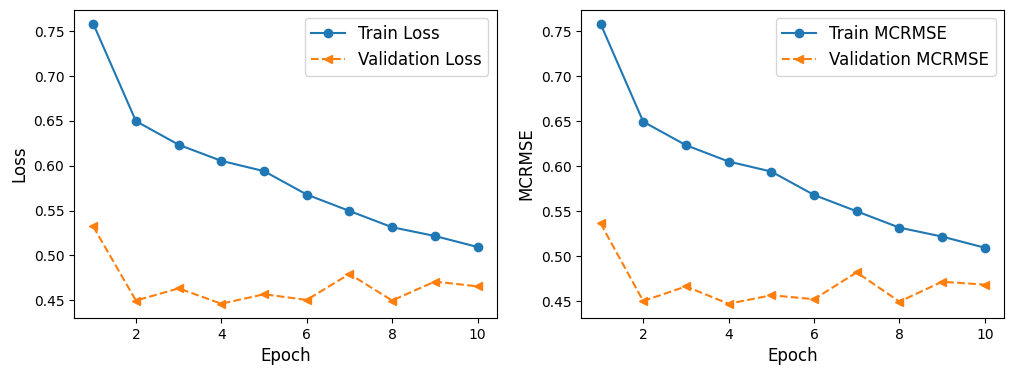

13/13 [==============================] - 16s 1s/step - loss: 0.4854 - MCRMSE: 0.4839

Evaluate Test Metrics:

Test loss: 0.4854

Test MCRMSE score: 0.4839 

13/13 [==============================] - 19s 1s/step


,NLP Model,Num_Trainable_layers,Trainable_Params,Non-Trainable_Params,Epochs,Optimizer,Test_MCRMSE,Test_Loss,Train_MCRMSE,Train_Loss,Val_MCRMSE,Val_Loss,Learning_Rate,Num_Hidden_Layers,Num_hidden_Units,Dropout,Batch_Size
0,bert-base-cased,0,"198,406","108,310,272",10,adam,0.4827,0.4860,0.5959,0.5958,0.4814,0.4811,0.00005,1,256,0.3,16
1,bert-base-cased,6,"198,406","108,310,272",10,adam,0.4752,0.4789,0.5951,0.5951,0.4736,0.4732,0.00005,1,256,0.3,16
2,bert-base-cased,12,"108,508,678",0,10,adam,0.4839,0.4854,0.5091,0.5094,0.4681,0.4656,0.00005,1,256,0.3,16


In [1008]:
run_regression_experiment(num_train_layers=np.arange(0,13,6),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          # dropout=0.3,
                          # learning_rate=0.00005,
                          batch_size=16,
                          activation='relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_4.csv')

## **Learning rate = 0.00005** with **batch size = 16** and **activation = 'gelu'**


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                           

None

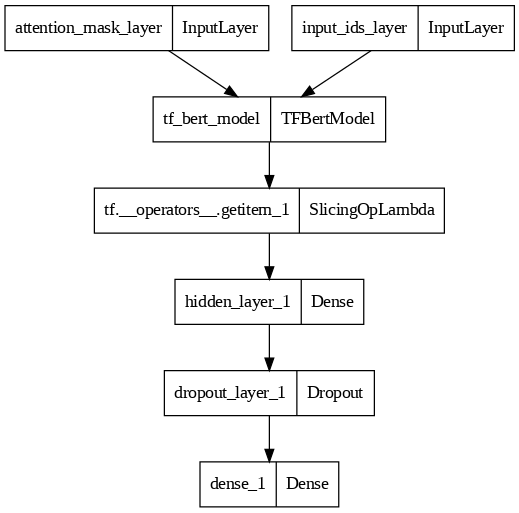

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 182s 857ms/step - loss: 1.2149 - MCRMSE: 1.2137 - val_loss: 0.5787 - val_MCRMSE: 0.5787
Epoch 2/10
196/196 [==============================] - 165s 842ms/step - loss: 0.7274 - MCRMSE: 0.7274 - val_loss: 0.5314 - val_MCRMSE: 0.5311
Epoch 3/10
196/196 [==============================] - 165s 840ms/step - loss: 0.6586 - MCRMSE: 0.6585 - val_loss: 0.5101 - val_MCRMSE: 0.5092
Epoch 4/10
196/196 [==============================] - 165s 844ms/step - loss: 0.6190 - MCRMSE: 0.6188 - val_loss: 0.4843 - val_MCRMSE: 0.4837
Epoch 5/10
196/196 [==============================] - 163s 832ms/step - loss: 0.6065 - MCRMSE: 0.6063 - val_loss: 0.4866 - val_MCRMSE: 0.4859
Epoch 6/10
196/196 [==============================] - 165s 840ms/step - loss: 0.5916 - MCRMSE: 0.5916 - val_loss: 0.4823 - val_MCRMSE: 0.4817
Epoch 7/10
196/196 [==============================] - 160s 819ms/step - loss: 0.5829 - MCRMSE: 0.5828 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.214936,0.727374,0.658634,0.619048,0.606490,0.591577,0.582862,0.571196,0.569065,0.560199
MCRMSE,1.213707,0.727405,0.658528,0.618849,0.606311,0.591619,0.582812,0.571121,0.569455,0.559908
val_loss,0.578723,0.531352,0.510064,0.484304,0.486630,0.482333,0.479535,0.469896,0.470328,0.461939
val_MCRMSE,0.578714,0.531056,0.509152,0.483745,0.485902,0.481711,0.478908,0.469501,0.469817,0.461698



Plotting loss and MCRMSE...


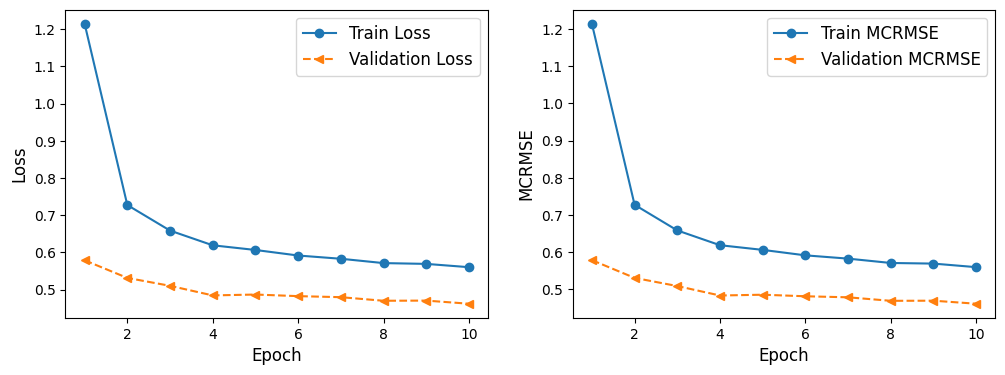

13/13 [==============================] - 16s 1s/step - loss: 0.4846 - MCRMSE: 0.4804

Evaluate Test Metrics:

Test loss: 0.4846

Test MCRMSE score: 0.4804 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

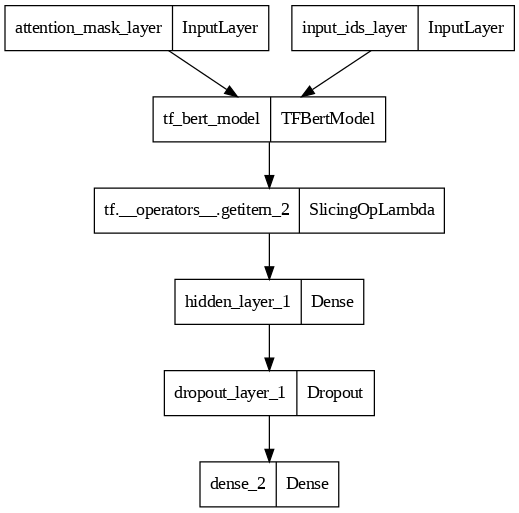

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 173s 832ms/step - loss: 1.3086 - MCRMSE: 1.3073 - val_loss: 0.5862 - val_MCRMSE: 0.5864
Epoch 2/10
196/196 [==============================] - 165s 843ms/step - loss: 0.7350 - MCRMSE: 0.7348 - val_loss: 0.5411 - val_MCRMSE: 0.5406
Epoch 3/10
196/196 [==============================] - 165s 843ms/step - loss: 0.6721 - MCRMSE: 0.6722 - val_loss: 0.5215 - val_MCRMSE: 0.5202
Epoch 4/10
196/196 [==============================] - 165s 843ms/step - loss: 0.6339 - MCRMSE: 0.6334 - val_loss: 0.4897 - val_MCRMSE: 0.4891
Epoch 5/10
196/196 [==============================] - 160s 818ms/step - loss: 0.6168 - MCRMSE: 0.6167 - val_loss: 0.4840 - val_MCRMSE: 0.4832
Epoch 6/10
196/196 [==============================] - 163s 831ms/step - loss: 0.5950 - MCRMSE: 0.5951 - val_loss: 0.4844 - val_MCRMSE: 0.4835
Epoch 7/10
196/196 [==============================] - 165s 843ms/step - loss: 0.5929 - MCRMSE: 0.5929 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.308598,0.734966,0.672115,0.633853,0.616755,0.595019,0.592891,0.578275,0.570130,0.566971
MCRMSE,1.307323,0.734833,0.672218,0.633413,0.616697,0.595131,0.592910,0.578308,0.570751,0.566694
val_loss,0.586228,0.541128,0.521517,0.489668,0.484047,0.484445,0.483869,0.477005,0.479745,0.465279
val_MCRMSE,0.586440,0.540602,0.520154,0.489073,0.483245,0.483504,0.483067,0.476323,0.479065,0.464957



Plotting loss and MCRMSE...


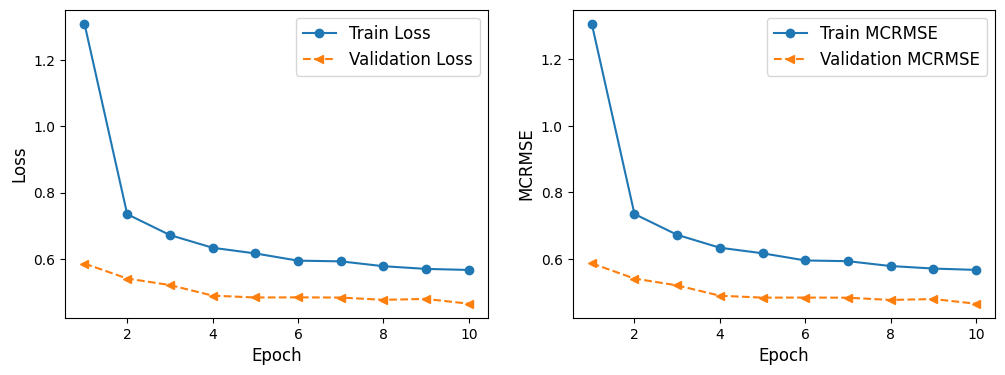

13/13 [==============================] - 16s 1s/step - loss: 0.4855 - MCRMSE: 0.4792

Evaluate Test Metrics:

Test loss: 0.4855

Test MCRMSE score: 0.4792 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 12
******************************************************

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
              

None

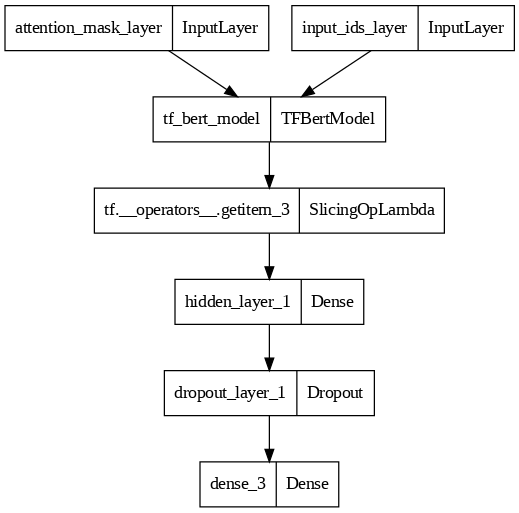

Training Regression with BERT.....
Epoch 1/10


196/196 [==============================] - 312s 1s/step - loss: 0.7350 - MCRMSE: 0.7345 - val_loss: 0.4591 - val_MCRMSE: 0.4590
Epoch 2/10
196/196 [==============================] - 273s 1s/step - loss: 0.6100 - MCRMSE: 0.6100 - val_loss: 0.4609 - val_MCRMSE: 0.4608
Epoch 3/10
196/196 [==============================] - 279s 1s/step - loss: 0.5760 - MCRMSE: 0.5758 - val_loss: 0.4415 - val_MCRMSE: 0.4415
Epoch 4/10
196/196 [==============================] - 268s 1s/step - loss: 0.5595 - MCRMSE: 0.5595 - val_loss: 0.4422 - val_MCRMSE: 0.4424
Epoch 5/10
196/196 [==============================] - 273s 1s/step - loss: 0.5326 - MCRMSE: 0.5328 - val_loss: 0.4569 - val_MCRMSE: 0.4572
Epoch 6/10
196/196 [==============================] - 273s 1s/step - loss: 0.5160 - MCRMSE: 0.5162 - val_loss: 0.4549 - val_MCRMSE: 0.4554
Epoch 7/10
196/196 [==============================] - 273s 1s/step - loss: 0.4984 - MCRMSE: 0.4984 - val_loss: 0.4597 - val_MCRMSE: 0.4605
Epoch 8/10
196/196 [==================

,0,1,2,3,4,5,6,7,8,9
loss,0.735047,0.609994,0.575966,0.559488,0.532606,0.516029,0.498396,0.478874,0.460236,0.456103
MCRMSE,0.734528,0.610033,0.575849,0.559535,0.532755,0.516155,0.498446,0.478987,0.460197,0.456029
val_loss,0.459074,0.460881,0.441491,0.442167,0.456905,0.454884,0.459659,0.481966,0.494160,0.466070
val_MCRMSE,0.458980,0.460834,0.441493,0.442404,0.457188,0.455405,0.460458,0.482662,0.493665,0.465268



Plotting loss and MCRMSE...


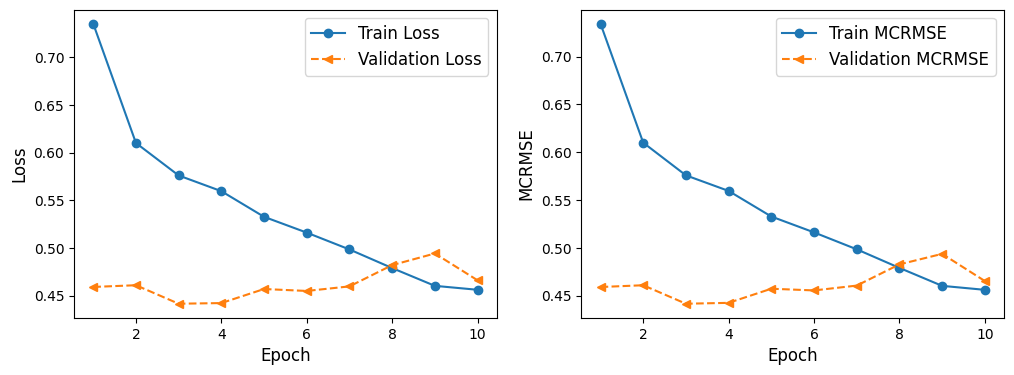

13/13 [==============================] - 16s 1s/step - loss: 0.4855 - MCRMSE: 0.4816

Evaluate Test Metrics:

Test loss: 0.4855

Test MCRMSE score: 0.4816 



In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,13,6),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          # dropout=0.3,
                          # learning_rate=0.00005,
                          batch_size=16,
                          activation='gelu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_gelu.csv')

## **Learning rate = 0.00005** with **batch size = 16**, **activation = 'gelu'**, and **2 or 4 unfrozen BERT layers**


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                             

None

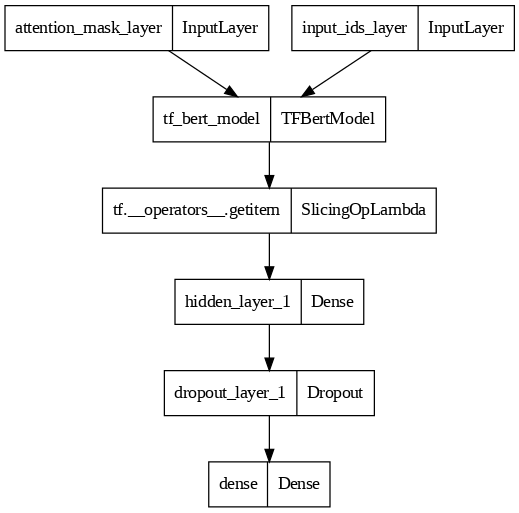

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 172s 796ms/step - loss: 1.3861 - MCRMSE: 1.3845 - val_loss: 0.5857 - val_MCRMSE: 0.5858
Epoch 2/10
196/196 [==============================] - 161s 821ms/step - loss: 0.7769 - MCRMSE: 0.7764 - val_loss: 0.5580 - val_MCRMSE: 0.5579
Epoch 3/10
196/196 [==============================] - 162s 827ms/step - loss: 0.7295 - MCRMSE: 0.7294 - val_loss: 0.5326 - val_MCRMSE: 0.5321
Epoch 4/10
196/196 [==============================] - 162s 825ms/step - loss: 0.6835 - MCRMSE: 0.6831 - val_loss: 0.5118 - val_MCRMSE: 0.5113
Epoch 5/10
105/196 [===============>..............] - ETA: 1:04 - loss: 0.6587 - MCRMSE: 0.6587

KeyboardInterrupt: ignored

In [85]:
# run_regression_experiment(num_train_layers=np.arange(0,7,2),
#                           # num_hidden_layer=1,
#                           # num_hidden_units=256,
#                           # dropout=0.3,
#                           learning_rate=0.00003,
#                           batch_size=16,
#                           activation='gelu',
#                           optimizer='adam',
#                           csv_filename='perf_summary_regression_w_BERT_batch16_gelu_2or4Unfrozen.csv')

## **Learning rate = 0.00005** with **batch size = 16** and **activation = 'leaky_relu'**


******************************************************
Regression with BERT: Number of Unfrozen Layers = 0
******************************************************

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['attention_mask_layer[0][0]',   
                             

None

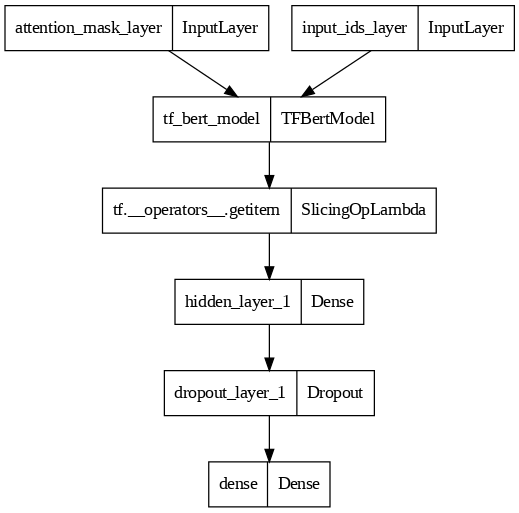

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 178s 836ms/step - loss: 1.2492 - MCRMSE: 1.2482 - val_loss: 0.5777 - val_MCRMSE: 0.5782
Epoch 2/10
196/196 [==============================] - 162s 825ms/step - loss: 0.7560 - MCRMSE: 0.7559 - val_loss: 0.5307 - val_MCRMSE: 0.5308
Epoch 3/10
196/196 [==============================] - 157s 799ms/step - loss: 0.6728 - MCRMSE: 0.6727 - val_loss: 0.5136 - val_MCRMSE: 0.5130
Epoch 4/10
196/196 [==============================] - 162s 828ms/step - loss: 0.6321 - MCRMSE: 0.6320 - val_loss: 0.4807 - val_MCRMSE: 0.4807
Epoch 5/10
196/196 [==============================] - 162s 826ms/step - loss: 0.6137 - MCRMSE: 0.6135 - val_loss: 0.4787 - val_MCRMSE: 0.4785
Epoch 6/10
196/196 [==============================] - 160s 815ms/step - loss: 0.5986 - MCRMSE: 0.5985 - val_loss: 0.4807 - val_MCRMSE: 0.4804
Epoch 7/10
196/196 [==============================] - 161s 824ms/step - loss: 0.5840 - MCRMSE: 0.5840 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.249227,0.755993,0.672789,0.632114,0.613663,0.598551,0.583993,0.578073,0.573448,0.562552
MCRMSE,1.248158,0.755942,0.672724,0.631997,0.613538,0.598519,0.583959,0.578038,0.573624,0.562300
val_loss,0.577718,0.530654,0.513588,0.480656,0.478708,0.480737,0.476151,0.468511,0.466885,0.462303
val_MCRMSE,0.578192,0.530823,0.512998,0.480713,0.478501,0.480427,0.476071,0.468689,0.466944,0.462578



Plotting loss and MCRMSE...


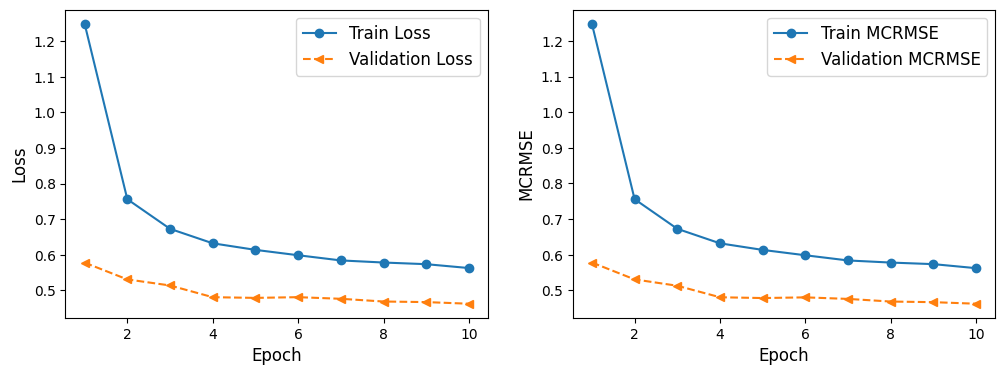

13/13 [==============================] - 15s 1s/step - loss: 0.4856 - MCRMSE: 0.4804

Evaluate Test Metrics:

Test loss: 0.4856

Test MCRMSE score: 0.4804 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 2
******************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

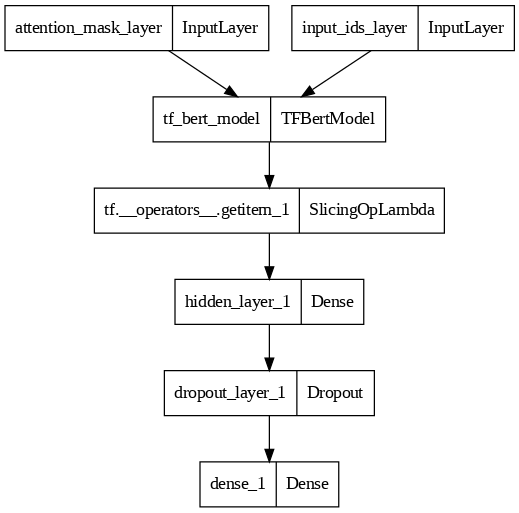

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 167s 818ms/step - loss: 1.3267 - MCRMSE: 1.3257 - val_loss: 0.5896 - val_MCRMSE: 0.5908
Epoch 2/10
196/196 [==============================] - 162s 826ms/step - loss: 0.7510 - MCRMSE: 0.7509 - val_loss: 0.5373 - val_MCRMSE: 0.5386
Epoch 3/10
196/196 [==============================] - 162s 828ms/step - loss: 0.6845 - MCRMSE: 0.6842 - val_loss: 0.5118 - val_MCRMSE: 0.5116
Epoch 4/10
196/196 [==============================] - 162s 826ms/step - loss: 0.6411 - MCRMSE: 0.6406 - val_loss: 0.4875 - val_MCRMSE: 0.4875
Epoch 5/10
196/196 [==============================] - 162s 826ms/step - loss: 0.6180 - MCRMSE: 0.6179 - val_loss: 0.4833 - val_MCRMSE: 0.4828
Epoch 6/10
196/196 [==============================] - 162s 825ms/step - loss: 0.6018 - MCRMSE: 0.6018 - val_loss: 0.4790 - val_MCRMSE: 0.4783
Epoch 7/10
196/196 [==============================] - 155s 789ms/step - loss: 0.5908 - MCRMSE: 0.5908 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.326679,0.750974,0.684485,0.641077,0.618007,0.601798,0.590827,0.577027,0.571431,0.563038
MCRMSE,1.325680,0.750934,0.684222,0.640641,0.617908,0.601775,0.590796,0.576906,0.571632,0.562798
val_loss,0.589590,0.537330,0.511834,0.487462,0.483308,0.479014,0.491236,0.473861,0.469226,0.461557
val_MCRMSE,0.590763,0.538642,0.511604,0.487457,0.482760,0.478271,0.490290,0.473097,0.468560,0.461150



Plotting loss and MCRMSE...


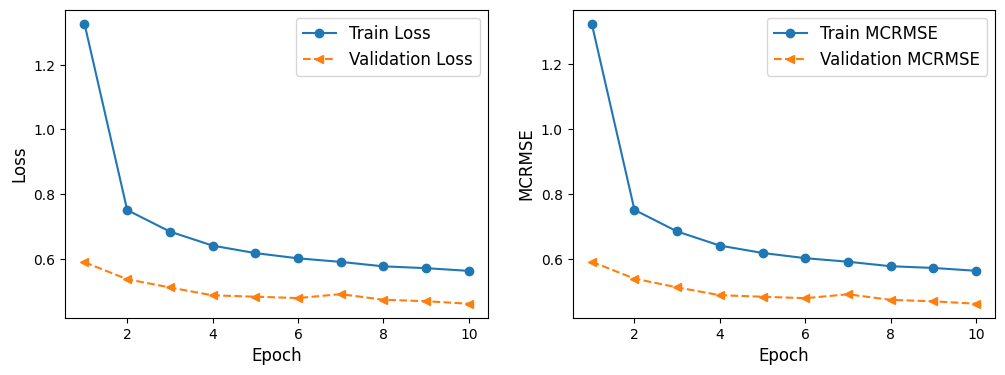

13/13 [==============================] - 15s 1s/step - loss: 0.4840 - MCRMSE: 0.4790

Evaluate Test Metrics:

Test loss: 0.4840

Test MCRMSE score: 0.4790 

13/13 [==============================] - 20s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 4
******************************************************

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

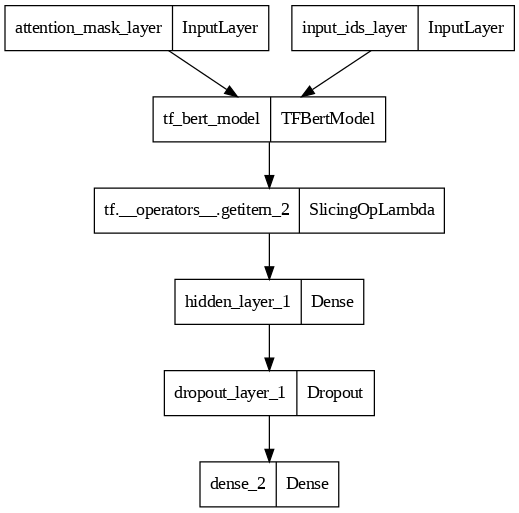

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 168s 814ms/step - loss: 1.3868 - MCRMSE: 1.3853 - val_loss: 0.5846 - val_MCRMSE: 0.5866
Epoch 2/10
196/196 [==============================] - 162s 827ms/step - loss: 0.7481 - MCRMSE: 0.7481 - val_loss: 0.5374 - val_MCRMSE: 0.5384
Epoch 3/10
196/196 [==============================] - 162s 826ms/step - loss: 0.6741 - MCRMSE: 0.6742 - val_loss: 0.5132 - val_MCRMSE: 0.5130
Epoch 4/10
196/196 [==============================] - 162s 827ms/step - loss: 0.6363 - MCRMSE: 0.6359 - val_loss: 0.4871 - val_MCRMSE: 0.4876
Epoch 5/10
196/196 [==============================] - 162s 826ms/step - loss: 0.6100 - MCRMSE: 0.6099 - val_loss: 0.4791 - val_MCRMSE: 0.4791
Epoch 6/10
196/196 [==============================] - 157s 800ms/step - loss: 0.5963 - MCRMSE: 0.5963 - val_loss: 0.4755 - val_MCRMSE: 0.4754
Epoch 7/10
196/196 [==============================] - 160s 815ms/step - loss: 0.5828 - MCRMSE: 0.5829 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.386774,0.748065,0.674136,0.636297,0.609998,0.596259,0.582762,0.572452,0.565565,0.563688
MCRMSE,1.385264,0.748075,0.674204,0.635910,0.609881,0.596347,0.582927,0.572563,0.565703,0.563558
val_loss,0.584610,0.537393,0.513199,0.487117,0.479121,0.475544,0.483856,0.468760,0.468834,0.460781
val_MCRMSE,0.586605,0.538436,0.513036,0.487605,0.479104,0.475423,0.483473,0.468672,0.468847,0.460966



Plotting loss and MCRMSE...


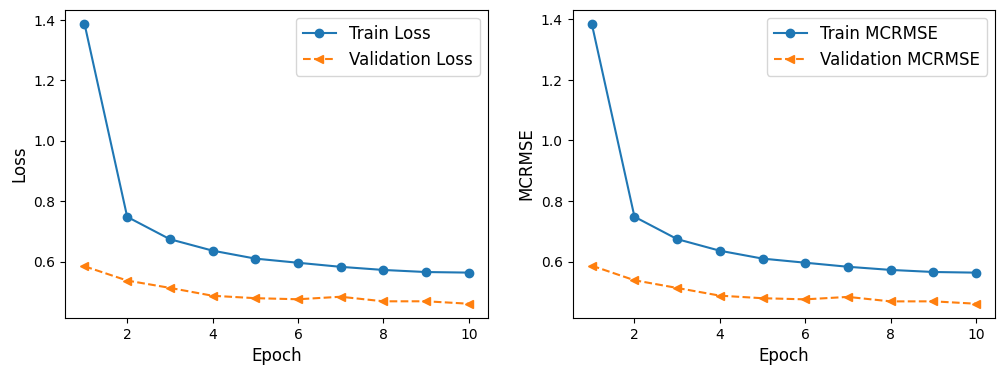

13/13 [==============================] - 15s 1s/step - loss: 0.4813 - MCRMSE: 0.4761

Evaluate Test Metrics:

Test loss: 0.4813

Test MCRMSE score: 0.4761 

13/13 [==============================] - 19s 1s/step

******************************************************
Regression with BERT: Number of Unfrozen Layers = 6
******************************************************

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
               

None

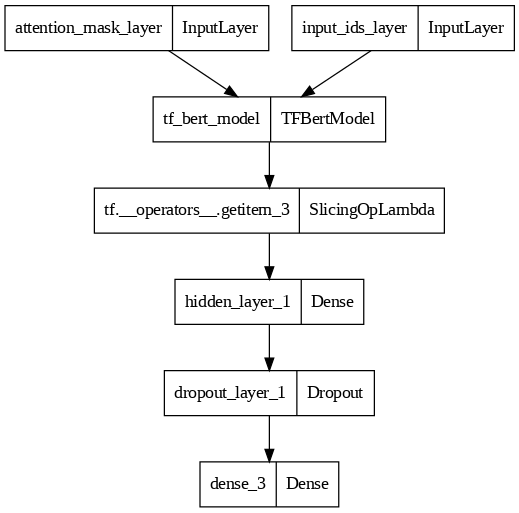

Training Regression with BERT.....
Epoch 1/10
196/196 [==============================] - 167s 816ms/step - loss: 1.1489 - MCRMSE: 1.1479 - val_loss: 0.5848 - val_MCRMSE: 0.5845
Epoch 2/10
196/196 [==============================] - 162s 826ms/step - loss: 0.7348 - MCRMSE: 0.7344 - val_loss: 0.5304 - val_MCRMSE: 0.5299
Epoch 3/10
196/196 [==============================] - 162s 825ms/step - loss: 0.6636 - MCRMSE: 0.6637 - val_loss: 0.5060 - val_MCRMSE: 0.5049
Epoch 4/10
196/196 [==============================] - 162s 828ms/step - loss: 0.6228 - MCRMSE: 0.6227 - val_loss: 0.4854 - val_MCRMSE: 0.4847
Epoch 5/10
196/196 [==============================] - 160s 815ms/step - loss: 0.6078 - MCRMSE: 0.6077 - val_loss: 0.4865 - val_MCRMSE: 0.4857
Epoch 6/10
196/196 [==============================] - 162s 826ms/step - loss: 0.5943 - MCRMSE: 0.5946 - val_loss: 0.4852 - val_MCRMSE: 0.4845
Epoch 7/10
196/196 [==============================] - 162s 827ms/step - loss: 0.5800 - MCRMSE: 0.5799 - val_loss:

,0,1,2,3,4,5,6,7,8,9
loss,1.148882,0.734771,0.663636,0.622816,0.607800,0.594325,0.580019,0.572637,0.564864,0.557869
MCRMSE,1.147872,0.734432,0.663695,0.622747,0.607723,0.594559,0.579869,0.572765,0.565187,0.557416
val_loss,0.584849,0.530383,0.506038,0.485448,0.486503,0.485213,0.474675,0.468936,0.468374,0.464170
val_MCRMSE,0.584522,0.529901,0.504862,0.484670,0.485691,0.484524,0.474203,0.468702,0.468225,0.464005



Plotting loss and MCRMSE...


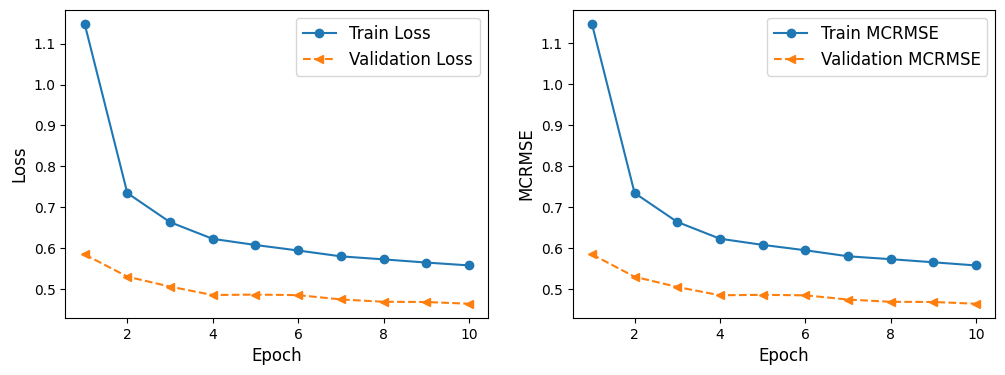

13/13 [==============================] - 15s 1s/step - loss: 0.4835 - MCRMSE: 0.4789

Evaluate Test Metrics:

Test loss: 0.4835

Test MCRMSE score: 0.4789 

13/13 [==============================] - 20s 1s/step


,NLP Model,Num_Trainable_layers,Epochs,Test_MCRMSE,Test_Loss,Train_MCRMSE,Train_Loss,Val_MCRMSE,Val_Loss,Optimizer,Activation,Learning_Rate,Num_Hidden_Layers,Num_hidden_Units,Dropout,Batch_Size
0,bert-base-cased,0,10,0.4804,0.4856,0.5623,0.5626,0.4626,0.4623,adam,leaky_relu,0.00005,1,256,0.3,16
1,bert-base-cased,2,10,0.4790,0.4840,0.5628,0.5630,0.4612,0.4616,adam,leaky_relu,0.00005,1,256,0.3,16
2,bert-base-cased,4,10,0.4761,0.4813,0.5636,0.5637,0.4610,0.4608,adam,leaky_relu,0.00005,1,256,0.3,16
3,bert-base-cased,6,10,0.4789,0.4835,0.5574,0.5579,0.4640,0.4642,adam,leaky_relu,0.00005,1,256,0.3,16


In [169]:
run_regression_experiment(num_train_layers=np.arange(0,7,2),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          # dropout=0.3,
                          # learning_rate=0.00005,
                          batch_size=16,
                          activation='leaky_relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu.csv')

In [ ]:
run_regression_experiment(num_train_layers=np.arange(2,5,2),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          # dropout=0.3,
                          # learning_rate=0.00005,
                          batch_size=16,
                          activation='relu',
                          optimizer='adam',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu.csv')

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,7,2),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          # dropout=0.3,
                          # learning_rate=0.00005,
                          batch_size=16,
                          activation='leaky_relu',
                          optimizer='sgd',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu_sgd.csv')

# 'epochs'                  : 5,
# 'batch_size'              : 4,
# 'learning_rate'           : 1e-5,
# 'validation_split'        : .2,
# 'dropout'                 : .1,
# 'number_of_hidden_layers' : 1,
# 'hidden_layer_node_count' : 64,
# 'retrain_layer_count'     : 0

In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,7,2),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          # dropout=0.3,
                          # learning_rate=0.00005,
                          batch_size=16,
                          activation='relu',
                          optimizer='sgd',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu_sgd.csv')


In [ ]:
run_regression_experiment(num_train_layers=np.arange(0,7,2),
                          # num_hidden_layer=1,
                          # num_hidden_units=256,
                          # dropout=0.3,
                          # learning_rate=0.00005,
                          batch_size=16,
                          activation='gelu',
                          optimizer='sgd',
                          csv_filename='perf_summary_regression_w_BERT_batch16_leakyRelu_sgd.csv')
